# Исследование эффективности работы сервиса Яндекс Афиша


- Автор: Ольга Агафонова
- Дата: 14.07.2025г.

### Цели и задачи проекта:

**Цель проекта** - проведение исследовательского анализа данных сервиса Яндекс Афиша в Python с целью выявления инсайтов об изменении пользовательских предпочтений и популярности событий осенью 2024 года, а также проверка гипотез о разнице в поведении пользователей с мобильными и стационарными устройствами.

**Задачи проекта:**

* Загрузка данных и оценка их целостности.
* Предварительная предобработка данных.
* Исследовательский анализ данных и определение статистических показателей.
* Проверка гипотез с помощью статистического теста.
* Общий вывод и рекомендации.

### Описание данных:

В работе будут использованы данные из  трёх датасетов:

- `final_tickets_orders_df.csv` — таблица включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных.

- `final_tickets_events_df.csv` — таблица содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. 

- `final_tickets_tenge_df.csv` — таблица с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге. 


Поля таблицы `final_tickets_orders_df.csv`:

- `order_id` — уникальный идентификатор заказа.
- `user_id` — уникальный идентификатор пользователя.
- `created_dt_msk` — дата создания заказа (московское время).
- `created_ts_msk` — дата и время создания заказа (московское время).
- `event_id` — идентификатор мероприятия из таблицы events.
- `cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- `age_limit` — возрастное ограничение мероприятия.
- `currency_code` — валюта оплаты, например rub для российских рублей.
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (mobile для мобильных устройств, desktop для стационарных).
- `revenue` — выручка от заказа.
- `service_name` — название билетного оператора.
- `tickets_count` — количество купленных билетов.
- `total` — общая сумма заказа.
- `days_since_prev` — количество дней с предыдущей покупки для каждого пользователя. 
   Если покупки не было, то данные содержат пропуск.
    
Cтолбцы датасета `final_tickets_events_df.csv`:  
    
- `event_id` — уникальный идентификатор мероприятия.
- `event_name` — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- `event_type_description` — описание типа мероприятия.
- `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее.
- `organizers` — организаторы мероприятия.
- `region_name` — название региона.
- `city_name` — название города.
- `city_id` - идентификатор города проведения мероприятия.  
- `venue_id` — уникальный идентификатор площадки.
- `venue_name` — название площадки.
- `venue_address` — адрес площадки.

Поля датасета `final_tickets_tenge_df.csv`:

- `nominal` — номинал (100 тенге).
- `data` — дата.
- `curs` — курс тенге к рублю.
- `cdx` — обозначение валюты (kzt).



### Содержимое проекта:

1. Загрузка данных и знакомство с ними.
2. Предобработка данных и подготовка их к исследованию.
3. Исследовательский анализ данных.
4. Статистический анализ данных.
5. Общий вывод и рекомендации.

---

## Загрузка данных и знакомство с ними

In [1]:
# Импортируем необходимые для анализа данных библиотеки и модули:
import pandas as pd
pd.set_option('display.max_columns', 100)

!pip install matplotlib_venn -q
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
import math

import warnings
warnings.simplefilter(action='ignore')

**Загрузим данные датасетов и проведем их проведем их предварительный анализ.**

In [2]:
# Сохраним путь к датасетам в переменную PATH и выгрузим поочередно все датасеты:
PATH = 'https://code.s3.yandex.net/datasets/'

Загрузка файла **'final_tickets_orders_df.csv'**.

In [3]:
# Считаем и сохраним в датафрейм `orders` датасет `final_tickets_orders_df.csv`. 
# Выведем на экран первые строки полученного датафрейма.
orders = pd.read_csv(PATH + 'final_tickets_orders_df.csv')
orders.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [4]:
# Выведем основную информацию о датафрейме `orders`.
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

Загрузка файла **'final_tickets_events_df.csv'**.

In [5]:
# Считаем и сохраним в датафрейм `events` файл `final_tickets_events_df.csv`. 
# Выведем на экран первые строки полученного датафрейма.
events = pd.read_csv(PATH + 'final_tickets_events_df.csv')
events.head()

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [6]:
# Выведем основную информацию о датафрейме `events`.
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


Загрузка файла **'final_tickets_tenge_df.csv'**.

In [7]:
# Считаем и сохраним в датафрейм `tenge` файл `final_tickets_tenge_df.csv`. 
# Выведем на экран первые строки полученного датафрейма.
tenge = pd.read_csv(PATH + 'final_tickets_tenge_df.csv')
tenge.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [8]:
# Выведем основную информацию о датафрейме `tenge`.
tenge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


---

### Сформируем промежуточный вывод относительно полученных данных:




**1. Датафрейм `orders`** занимает объем оперативной памяти 31.1 МВ и содержит 290849 строк и 14 столбцов, в которых находится информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных.

Изучим типы данных и их корректность.
В датасете представлены три типа данных: 


**Числовые значения с плавающей точкой (float64).** Три столбца представлены в данном типе: 

* `revenue`, `total` - выручка от заказа и общая сумма заказа соответственно. Тип данных float64 подходит для содержимого данных столбцов, так как значение может быть дробным числом.
* `days_since_prev` - содержит информацию о количестве дней с предыдущей покупки для каждого пользователя и, если покупки не было, то данные являются пропусками. Здесь вещественный тип данных не является корректным, так как количество дней соответствует целочисленному типу данных. Следовательно, значения столбца необходимо привести к типу данных Int64. 

**Строковые данные (object).** Семь столбцов имеют тип данных object:

* `user_id`, `cinema_circuit`, `currency_code`, `device_type_canonical`, `service_name` - столбцы имеют строковые значения (object), что вполне соответствует их содержимому: буквенное или буквенно-численное. 
* `created_dt_msk` и `created_ts_msk` - столбцы с информацией о дате и дате/времени заказа не соответствуют типу данных object, их нужно привести к типу datetime64.

**Целочисленные значения (int64).** Четыре столбца с данным типом:

* `order_id`, `event_id`, `age_limit`, `tickets_count` - тип данных int64 является типичным для значений указанных столбцов.

Проанализировав типы данных видно, что все столбцы представлены корректно, кроме столбцов `created_dt_msk`, `created_ts_msk` и `days_since_prev`, которые удобнее будет привести к типам данных, соответствующим их содержимому. Так же, отметим, что в столбце `days_since_prev` присутствуют пропуски, которые можно заменить на нулевое значение либо оставить без изменений.


**2. Обратимся к датафрейму `events`**, который занимает 1.9 МВ объема оперативной памяти и содержит 22427 строк и 11 столбцов, в которых информация о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия.

По аналогии с предыдущим датасетом можно отметить, что данные датафрейма представлены в двух типах: 


**Целочисленные значения (int64).** Три столбца представлены в данном типе: 

* `event_id`, `city_id` и `venue_id` - идентификаторы мероприятия, города и площадки соответственно. Целочисленный тип данных подходит для содержимого данных столбцов.

**Строковые данные (object).** Восемь столбцов имеют тип данных object:

* Остальные столбцы датафрейма имеют строковые значения (object), что вполне соответствует их содержимому: буквенное или буквенно-численное. 

Изучив типы данных видно, что все столбцы представлены корректно. Отметим, что поля датафрейма не содержат пропусков.


**3. Перейдем к датафрейму `tenge`** занимает объем оперативной памяти 11.3 KВ и содержит 357 строк и 4 столбца, в которых находится информация о курсе тенге к российскому рублю за 2024 год.

В датасете представлены три типа данных: 


**Числовые значения с плавающей точкой (float64).** Один столбец представлен в данном типе: 

* `curs` - курс тенге к рублю. Тип данных float64 подходит для значений данного столбца.

**Строковые данные (object).** Два столбца имеют тип данных object:

* `cdx` - столбцы содержат обозначение валюты (kzt), что вполне соответствует их содержимому. 
* `data` - столбец с информацией о дате не соответствуют типу данных object, знпчения столбца необходимо привести к типу datetime64.

**Целочисленные значения (int64).** Один столбец с данным типом:

* `nominal` - номинал, тип данных int64 является типичным для значений указанного столбца.

Проанализировав типы данных видно, что все столбцы представлены корректно, кроме столбца `data`, который требует приведения к типу даты. Столбцы данного датафрейма не содержат пропущенных значений.


Кроме того, отметим, что названия столбцов датафреймов прописаны в соответствии стилю **snake case** - в нижнем регистре с разделением слов подчеркиваниями вместо пробелов.

Судя по первому знакомству с данными датасетов, значения в столбцах соответствуют своему описанию.

---

## Предобработка данных и подготовка их к исследованию

* **Для удобства объединим имеющиеся датафреймы.**

In [9]:
# Объединим таблицы orders и events в общий датафрейм oe_df:
oe_df = pd.merge(orders, events, on='event_id')
display(oe_df)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7431164,024dc5236465850,2024-07-23,2024-07-23 20:52:02,169230,нет,16,rub,mobile,1902.42,Край билетов,5,13588.74,0.0,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
2,7431106,024dc5236465850,2024-07-23,2024-07-23 20:54:19,169230,нет,16,rub,mobile,1141.45,Край билетов,3,8153.25,0.0,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
3,7431135,024dc5236465850,2024-07-23,2024-07-23 20:59:44,169230,нет,16,rub,mobile,1902.42,Край билетов,5,13588.74,0.0,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
4,7431048,024dc5236465850,2024-07-23,2024-07-23 21:02:08,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,0.0,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,7375078,ff684621b134cc4,2024-10-06,2024-10-06 12:32:09,12820,нет,18,rub,desktop,279.82,Лови билет!,3,3497.70,3.0,a59dafa6-f5a0-4c98-a460-5f6bb27218df,спектакль,театр,№1871,Каменевский регион,Глиногорск,213,4574,"Архив ""Туман"" Лимитед","ш. Водопроводное, д. 87 стр. 572"
290607,343390,ff684621b134cc4,2024-10-31,2024-10-31 12:27:42,357588,нет,6,rub,mobile,427.06,Лови билет!,4,3285.04,1.0,f56f3d67-4673-4fb3-b202-3f2bfd39fcf6,мюзикл,театр,№1469,Североярская область,Озёрск,2,2303,"Санкт-Петербургский дом культуры ""Сказка"" Лтд","алл. Макарова, д. 5/2"
290608,7378935,ff6bf53a0207b52,2024-10-02,2024-10-02 20:58:31,300765,нет,6,rub,mobile,224.88,Городской дом культуры,3,2811.03,0.0,cf71bf2b-8e5c-47e0-a0f3-c2d4910c4677,спектакль,театр,№4915,Североярская область,Озёрск,2,3850,"Творческое объединение ""Ветер"" Инкорпорэйтед","пр. Тупиковый, д. 9 стр. 8"
290609,195084,ffdadadd5de9c4b,2024-07-22,2024-07-22 13:44:54,540339,нет,6,rub,desktop,92.18,Лови билет!,1,1316.83,0.0,f17a01b7-3cd3-4cd1-919c-3459bd074886,концерт,концерты,№1742,Светополянский округ,Глиноград,54,3692,"Цирк ""Зависть"" Групп","ул. Красина, д. 64 стр. 5/7"


Присоединим к полученному датафрейму `oe_df` таблицу `tenge`.

In [10]:
# Объединим таблицы oe_df и tenge в общий датафрейм total_df:
total_df = pd.merge(oe_df, tenge, left_on='created_dt_msk', right_on='data')
display(total_df)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.6972,kzt
1,6274963,44c1c640a242aea,2024-08-20,2024-08-20 22:12:04,237325,нет,0,rub,mobile,144.73,Мой билет,1,1033.76,0.0,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213,2941,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-08-20,100,18.6972,kzt
2,474528,2b1f730d7024681,2024-08-20,2024-08-20 15:29:56,373657,нет,18,rub,mobile,318.27,Облачко,3,2448.25,2.0,990b8b09-85d8-4ffb-9074-ab5303cd3c33,шоу,стендап,№1124,Североярская область,Озёрск,2,1631,"Музей истории ""Воспоминание"" Групп","наб. Тамбовская, д. 1/4 к. 577",2024-08-20,100,18.6972,kzt
3,7477361,05ba93f1b1e1fdd,2024-08-20,2024-08-20 17:06:44,534657,нет,16,rub,mobile,339.61,Быстробилет,1,2612.35,1.0,dff567b7-11a5-4c4c-b223-70c8ab7efd15,концерт,концерты,№1134,Ветренский регион,Кокжар,20,2866,"Школа фотографии ""Золотое"" Инк","ш. Микрорайон, д. 79 стр. 50",2024-08-20,100,18.6972,kzt
4,472150,3ee7dc2e115847f,2024-08-20,2024-08-20 02:57:22,534657,нет,16,rub,mobile,339.61,Быстробилет,1,2612.35,0.0,dff567b7-11a5-4c4c-b223-70c8ab7efd15,концерт,концерты,№1134,Ветренский регион,Кокжар,20,2866,"Школа фотографии ""Золотое"" Инк","ш. Микрорайон, д. 79 стр. 50",2024-08-20,100,18.6972,kzt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,236989,e75abeba6dd1fc4,2024-06-14,2024-06-14 18:21:55,10229,нет,12,rub,desktop,843.87,Лови билет!,5,10548.38,0.0,7e589239-e102-4205-9e8b-5983de8874b0,спектакль,театр,№1684,Каменевский регион,Глиногорск,213,2927,"Спектакль ""Сентябрь"" Лтд","ул. Красноярская, д. 6/3 стр. 761",2024-06-14,100,19.5250,kzt
290607,8365544,f29a8ec731fab1d,2024-06-14,2024-06-14 14:29:42,488578,нет,6,rub,mobile,230.75,Билеты в руки,5,3845.90,NaN,8183e81d-7f2d-4eeb-8fa6-506778e52f94,событие,другое,№2929,Светополянский округ,Речное,20595,2703,"Музей музыкальных инструментов ""Разноцвет"" и п...","пр. Коллективный, д. 5 к. 6/8",2024-06-14,100,19.5250,kzt
290608,7032588,f7a0146fc193947,2024-06-14,2024-06-14 23:28:07,518322,нет,12,rub,mobile,749.53,Билеты в руки,3,6813.90,0.0,3301cd59-29cc-460f-92f8-92bfac5d2148,спектакль,театр,№4439,Североярская область,Озёрск,2,1044,"Спектакль ""Ремесло"" Инк","алл. Степная, д. 5 стр. 9",2024-06-14,100,19.5250,kzt
290609,6730350,fc950d43881de43,2024-06-14,2024-06-14 06:56:17,533051,нет,18,rub,mobile,162.13,Облачко,2,1473.90,0.0,6a2e08b2-bf15-4424-8c60-5764e38a5d58,шоу,стендап,№2475,Светополянский округ,Глиноград,54,1244,"Группа арт-менеджеров ""Салон"" Групп","бул. Гаражный, д. 332 стр. 3",2024-06-14,100,19.5250,kzt


*Получили датафрейм `total_df`, содержащий 290611 строк и 28 столбцов.*

* **Предварительный анализ показал, что пропуски в столбцах датафреймов отсутствуют, кроме столбца `days_since_prev`. Подтвердим это функционально.**

In [11]:
# Выведем сумму пропусков, если они имеются:
total_df.isna().sum()

order_id                      0
user_id                       0
created_dt_msk                0
created_ts_msk                0
event_id                      0
cinema_circuit                0
age_limit                     0
currency_code                 0
device_type_canonical         0
revenue                       0
service_name                  0
tickets_count                 0
total                         0
days_since_prev           21913
event_name                    0
event_type_description        0
event_type_main               0
organizers                    0
region_name                   0
city_name                     0
city_id                       0
venue_id                      0
venue_name                    0
venue_address                 0
data                          0
nominal                       0
curs                          0
cdx                           0
dtype: int64

* **Проведем преобразование следующих столбов датафрейма: `days_since_prev` приведем к целочисленному типу данных, а колонки `created_dt_msk`, `created_ts_msk` и `data`-  к типу datetime64. Также обратим внимание на размерность числовых столбцов (тип данных 'int64' и 'float64'), которую следует оптимизировать (уменьшить).**

In [12]:
# Преобразуем данные столбца 'days_since_prev' типа float64 в целочисленный тип данных (Int64) с учетом размерности,  
# оставив пропущенные значения без изменений (как NaN):
total_df['days_since_prev'] = total_df['days_since_prev'].astype('Int16')

total_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,<NA>,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.6972,kzt
1,6274963,44c1c640a242aea,2024-08-20,2024-08-20 22:12:04,237325,нет,0,rub,mobile,144.73,Мой билет,1,1033.76,0,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213,2941,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-08-20,100,18.6972,kzt
2,474528,2b1f730d7024681,2024-08-20,2024-08-20 15:29:56,373657,нет,18,rub,mobile,318.27,Облачко,3,2448.25,2,990b8b09-85d8-4ffb-9074-ab5303cd3c33,шоу,стендап,№1124,Североярская область,Озёрск,2,1631,"Музей истории ""Воспоминание"" Групп","наб. Тамбовская, д. 1/4 к. 577",2024-08-20,100,18.6972,kzt
3,7477361,05ba93f1b1e1fdd,2024-08-20,2024-08-20 17:06:44,534657,нет,16,rub,mobile,339.61,Быстробилет,1,2612.35,1,dff567b7-11a5-4c4c-b223-70c8ab7efd15,концерт,концерты,№1134,Ветренский регион,Кокжар,20,2866,"Школа фотографии ""Золотое"" Инк","ш. Микрорайон, д. 79 стр. 50",2024-08-20,100,18.6972,kzt
4,472150,3ee7dc2e115847f,2024-08-20,2024-08-20 02:57:22,534657,нет,16,rub,mobile,339.61,Быстробилет,1,2612.35,0,dff567b7-11a5-4c4c-b223-70c8ab7efd15,концерт,концерты,№1134,Ветренский регион,Кокжар,20,2866,"Школа фотографии ""Золотое"" Инк","ш. Микрорайон, д. 79 стр. 50",2024-08-20,100,18.6972,kzt


In [13]:
# Приведем значения столбцов 'created_dt_msk', 'created_ts_msk' и 'data' строкового типа к типу данных datetime64,  
# используя метод to_datetime() и цикл:
for column in ['created_dt_msk','created_ts_msk','data']:
    total_df[column] = pd.to_datetime(total_df[column])
    
# Выведем полученные типы данных:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290611 non-null  int64         
 1   user_id                 290611 non-null  object        
 2   created_dt_msk          290611 non-null  datetime64[ns]
 3   created_ts_msk          290611 non-null  datetime64[ns]
 4   event_id                290611 non-null  int64         
 5   cinema_circuit          290611 non-null  object        
 6   age_limit               290611 non-null  int64         
 7   currency_code           290611 non-null  object        
 8   device_type_canonical   290611 non-null  object        
 9   revenue                 290611 non-null  float64       
 10  service_name            290611 non-null  object        
 11  tickets_count           290611 non-null  int64         
 12  total                   290611

In [14]:
# Оптимизируем размерность столбцов датафрейма 'total_df'с целочисленным типом данных, 
# используя метод to_numeric(). Зададим цикл:
for column in ['order_id','event_id','age_limit','tickets_count','event_id','city_id','venue_id','nominal']:
    total_df[column] = pd.to_numeric(total_df[column],
                                    downcast='integer')
    
# Проверим типы данных в столбцах датафрейма:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290611 non-null  int32         
 1   user_id                 290611 non-null  object        
 2   created_dt_msk          290611 non-null  datetime64[ns]
 3   created_ts_msk          290611 non-null  datetime64[ns]
 4   event_id                290611 non-null  int32         
 5   cinema_circuit          290611 non-null  object        
 6   age_limit               290611 non-null  int8          
 7   currency_code           290611 non-null  object        
 8   device_type_canonical   290611 non-null  object        
 9   revenue                 290611 non-null  float64       
 10  service_name            290611 non-null  object        
 11  tickets_count           290611 non-null  int8          
 12  total                   290611

In [15]:
# Аналогично, оптимизируем размерность столбцов датафрейма 'total_df'
# с вещественным типом данных:
for column in ['revenue','total','curs']:
    total_df[column] = pd.to_numeric(total_df[column],
                                    downcast='float')
    
# Проверим типы данных:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290611 non-null  int32         
 1   user_id                 290611 non-null  object        
 2   created_dt_msk          290611 non-null  datetime64[ns]
 3   created_ts_msk          290611 non-null  datetime64[ns]
 4   event_id                290611 non-null  int32         
 5   cinema_circuit          290611 non-null  object        
 6   age_limit               290611 non-null  int8          
 7   currency_code           290611 non-null  object        
 8   device_type_canonical   290611 non-null  object        
 9   revenue                 290611 non-null  float32       
 10  service_name            290611 non-null  object        
 11  tickets_count           290611 non-null  int8          
 12  total                   290611

***Подитожим:***

*Оптимизированный датафрейм 'total_df' имеет объем оперативной памяти 48.8 MВ, содержит 290611 строк и 28 столбцов со следующими типами данных: 'float32'(3 столбца), 'datetime64(3), 'Int16'(1), 'int16(1)', 'int32(3)', 'int8'(3) и 'object'(14).*

* **Проверим данные на явные и неявные дубликаты. Для оптимизации проверки проведём нормализацию данных в текстовых столбцах.**

In [16]:
# Нормализуем текстовые значения всех столбцов датафрейма total_df
# и приведем их к нижнему регистру, используя метод str.lower(), 
# а также избавимся от возможных пробелов в строке методом str.strip():
for column in total_df.select_dtypes(include=['object']).columns:
    total_df[column] = total_df[column].astype(str).str.lower().str.strip()

# Выведем результат
total_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.939941,край билетов,4,10870.990234,<NA>,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,каменевский регион,глиногорск,213,3972,"сценический центр ""деталь"" групп","алл. машиностроителей, д. 19 стр. 6",2024-08-20,100,18.697201,kzt
1,6274963,44c1c640a242aea,2024-08-20,2024-08-20 22:12:04,237325,нет,0,rub,mobile,144.729996,мой билет,1,1033.760010,0,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,каменевский регион,глиногорск,213,2941,"музыкальная школа для детей ""аккаунт"" лтд","алл. шмидта, д. 9 стр. 4",2024-08-20,100,18.697201,kzt
2,474528,2b1f730d7024681,2024-08-20,2024-08-20 15:29:56,373657,нет,18,rub,mobile,318.269989,облачко,3,2448.250000,2,990b8b09-85d8-4ffb-9074-ab5303cd3c33,шоу,стендап,№1124,североярская область,озёрск,2,1631,"музей истории ""воспоминание"" групп","наб. тамбовская, д. 1/4 к. 577",2024-08-20,100,18.697201,kzt
3,7477361,05ba93f1b1e1fdd,2024-08-20,2024-08-20 17:06:44,534657,нет,16,rub,mobile,339.609985,быстробилет,1,2612.350098,1,dff567b7-11a5-4c4c-b223-70c8ab7efd15,концерт,концерты,№1134,ветренский регион,кокжар,20,2866,"школа фотографии ""золотое"" инк","ш. микрорайон, д. 79 стр. 50",2024-08-20,100,18.697201,kzt
4,472150,3ee7dc2e115847f,2024-08-20,2024-08-20 02:57:22,534657,нет,16,rub,mobile,339.609985,быстробилет,1,2612.350098,0,dff567b7-11a5-4c4c-b223-70c8ab7efd15,концерт,концерты,№1134,ветренский регион,кокжар,20,2866,"школа фотографии ""золотое"" инк","ш. микрорайон, д. 79 стр. 50",2024-08-20,100,18.697201,kzt


* Проанализируем поочередно все уникальные значения в текстовых столбцах датафрейма, используя методы unique() и nunique().

In [17]:
# Посчитаем количество уникальных значений в столбцах типа object.
# Создадим список столбцов columns_unique:
columns_nunique = ['user_id','cinema_circuit','currency_code',
                  'device_type_canonical','service_name',
                  'event_name','event_type_description',
                  'event_type_main','organizers','region_name',
                  'city_name','venue_name','venue_address','cdx']

# Создадим словарь для хранения результатов:
unique_counts = {}

# Вычислим количество уникальных значений для каждого столбца:
for column in columns_nunique:
    unique_counts[column] = total_df[column].nunique()

# Выведем результаты
for column, count in unique_counts.items():
    print(f"Уникальных значений в столбце '{column}': {count}")

Уникальных значений в столбце 'user_id': 21933
Уникальных значений в столбце 'cinema_circuit': 6
Уникальных значений в столбце 'currency_code': 2
Уникальных значений в столбце 'device_type_canonical': 2
Уникальных значений в столбце 'service_name': 36
Уникальных значений в столбце 'event_name': 15248
Уникальных значений в столбце 'event_type_description': 20
Уникальных значений в столбце 'event_type_main': 7
Уникальных значений в столбце 'organizers': 4293
Уникальных значений в столбце 'region_name': 81
Уникальных значений в столбце 'city_name': 352
Уникальных значений в столбце 'venue_name': 3217
Уникальных значений в столбце 'venue_address': 3225
Уникальных значений в столбце 'cdx': 1


In [18]:
# Выведем уникальные значения столбцов, количество которых позволяет это сделать.
# Создадим список столбцов columns_unique:
columns_unique = ['cinema_circuit','currency_code',
                  'device_type_canonical','service_name',
                  'event_type_description',
                  'event_type_main','cdx']

# Создадим словарь для хранения результатов:
unique_names = {}

# Представим список уникальных значений для каждого отобранного столбца:
for column in columns_unique:
    unique_names[column] = total_df[column].unique()

# Выведем результаты
for column, count in unique_names.items():
    print(f"Уникальных значений в столбце '{column}': {count}")

Уникальных значений в столбце 'cinema_circuit': ['нет' 'москино' 'другое' 'киносити' 'киномакс' 'центрфильм']
Уникальных значений в столбце 'currency_code': ['rub' 'kzt']
Уникальных значений в столбце 'device_type_canonical': ['mobile' 'desktop']
Уникальных значений в столбце 'service_name': ['край билетов' 'мой билет' 'облачко' 'быстробилет' 'билеты без проблем'
 'весь в билетах' 'билеты в руки' 'прачечная' 'лови билет!'
 'лучшие билеты' 'дом культуры' 'за билетом!' 'яблоко' 'show_ticket'
 'тебе билет!' 'мир касс' 'выступления.ру' 'восьмёрка'
 'городской дом культуры' 'росбилет' 'вперёд!' 'crazy ticket!' 'телебилет'
 'радио ticket' 'кино билет' 'зе бест!' 'карандашру' 'шоу начинается!'
 'лимоны' 'билет по телефону' 'тех билет' 'дырокол' 'быстрый кассир'
 'реестр' 'цвет и билет' 'билеты в интернете']
Уникальных значений в столбце 'event_type_description': ['спектакль' 'событие' 'шоу' 'концерт' 'ёлка' 'цирковое шоу' 'выставка'
 'мюзикл' 'фестиваль' 'балет' 'спортивное мероприятие' 'спор

*Во всех столбцах значения выглядят уникальными, кроме столбца с описанием мероприятий `event_type_description`. Здесь некоторые значения по смыслу повторяются, поэтому их можно привести к единому названию.*

In [19]:
# С помощью метода str.replace() внесём необходимые изменения в столбец event_type_description:
total_df['event_type_description'] = total_df['event_type_description'].str.replace('спортивное мероприятие', 'спорт')
total_df['event_type_description'] = total_df['event_type_description'].str.replace('музыкальный спектакль', 'мюзикл')
total_df['event_type_description'] = total_df['event_type_description'].str.replace('подарок', 'ёлка')
total_df['event_type_description'] = total_df['event_type_description'].str.replace('снегурочка', 'ёлка')

# Получим результат
display(total_df)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.939941,край билетов,4,10870.990234,<NA>,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,каменевский регион,глиногорск,213,3972,"сценический центр ""деталь"" групп","алл. машиностроителей, д. 19 стр. 6",2024-08-20,100,18.697201,kzt
1,6274963,44c1c640a242aea,2024-08-20,2024-08-20 22:12:04,237325,нет,0,rub,mobile,144.729996,мой билет,1,1033.760010,0,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,каменевский регион,глиногорск,213,2941,"музыкальная школа для детей ""аккаунт"" лтд","алл. шмидта, д. 9 стр. 4",2024-08-20,100,18.697201,kzt
2,474528,2b1f730d7024681,2024-08-20,2024-08-20 15:29:56,373657,нет,18,rub,mobile,318.269989,облачко,3,2448.250000,2,990b8b09-85d8-4ffb-9074-ab5303cd3c33,шоу,стендап,№1124,североярская область,озёрск,2,1631,"музей истории ""воспоминание"" групп","наб. тамбовская, д. 1/4 к. 577",2024-08-20,100,18.697201,kzt
3,7477361,05ba93f1b1e1fdd,2024-08-20,2024-08-20 17:06:44,534657,нет,16,rub,mobile,339.609985,быстробилет,1,2612.350098,1,dff567b7-11a5-4c4c-b223-70c8ab7efd15,концерт,концерты,№1134,ветренский регион,кокжар,20,2866,"школа фотографии ""золотое"" инк","ш. микрорайон, д. 79 стр. 50",2024-08-20,100,18.697201,kzt
4,472150,3ee7dc2e115847f,2024-08-20,2024-08-20 02:57:22,534657,нет,16,rub,mobile,339.609985,быстробилет,1,2612.350098,0,dff567b7-11a5-4c4c-b223-70c8ab7efd15,концерт,концерты,№1134,ветренский регион,кокжар,20,2866,"школа фотографии ""золотое"" инк","ш. микрорайон, д. 79 стр. 50",2024-08-20,100,18.697201,kzt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,236989,e75abeba6dd1fc4,2024-06-14,2024-06-14 18:21:55,10229,нет,12,rub,desktop,843.869995,лови билет!,5,10548.379883,0,7e589239-e102-4205-9e8b-5983de8874b0,спектакль,театр,№1684,каменевский регион,глиногорск,213,2927,"спектакль ""сентябрь"" лтд","ул. красноярская, д. 6/3 стр. 761",2024-06-14,100,19.525000,kzt
290607,8365544,f29a8ec731fab1d,2024-06-14,2024-06-14 14:29:42,488578,нет,6,rub,mobile,230.750000,билеты в руки,5,3845.899902,<NA>,8183e81d-7f2d-4eeb-8fa6-506778e52f94,событие,другое,№2929,светополянский округ,речное,20595,2703,"музей музыкальных инструментов ""разноцвет"" и п...","пр. коллективный, д. 5 к. 6/8",2024-06-14,100,19.525000,kzt
290608,7032588,f7a0146fc193947,2024-06-14,2024-06-14 23:28:07,518322,нет,12,rub,mobile,749.530029,билеты в руки,3,6813.899902,0,3301cd59-29cc-460f-92f8-92bfac5d2148,спектакль,театр,№4439,североярская область,озёрск,2,1044,"спектакль ""ремесло"" инк","алл. степная, д. 5 стр. 9",2024-06-14,100,19.525000,kzt
290609,6730350,fc950d43881de43,2024-06-14,2024-06-14 06:56:17,533051,нет,18,rub,mobile,162.130005,облачко,2,1473.900024,0,6a2e08b2-bf15-4424-8c60-5764e38a5d58,шоу,стендап,№2475,светополянский округ,глиноград,54,1244,"группа арт-менеджеров ""салон"" групп","бул. гаражный, д. 332 стр. 3",2024-06-14,100,19.525000,kzt


In [20]:
# Проверим результат:
unique_events_type = total_df['event_type_description'].unique()

print(unique_events_type)

['спектакль' 'событие' 'шоу' 'концерт' 'ёлка' 'цирковое шоу' 'выставка'
 'мюзикл' 'фестиваль' 'балет' 'спорт' 'опера' 'экскурсия'
 'кукольный спектакль' 'оперетта' 'рок-мюзикл']


*Работа по выявлению неявных дубликатов проведена. Перейдём к устранению явных дубликатов в данных.*

In [21]:
# Посчитаем количество строк до удаления дубликатов с помощью метода shape[0] и результат сохраним 
# в переменную initial_row_count:
initial_row_count = total_df.shape[0]

# Сортируем датафрейм по всем столбцам, используя метод sort_values():
df_sorted = total_df.sort_values(by=list(total_df.columns))

# Определим количество дубликатов методом duplicated():
duplicates = df_sorted[df_sorted.duplicated(keep=False)].shape[0]

# Проведем удаление дубликатов в переменной df_no_duplicates с помощью метода drop_duplicates():
df_no_duplicates = df_sorted.drop_duplicates()

# Сохраним количество строк после удаления дубликатов в переменной final_row_count:
final_row_count = df_no_duplicates.shape[0]

# Выведем результат:
print(f'Количество строк до удаления дубликатов:{initial_row_count}')
print(f'Количество найденных дубликатов:{duplicates}')
print(f'Количество строк после удаления дубликатов:{final_row_count}')

Количество строк до удаления дубликатов:290611
Количество найденных дубликатов:0
Количество строк после удаления дубликатов:290611


*На первый взгляд, явных дубликатов нет, но рассмотрим столбцы, которые в совокупности дают информацию о бронировании билетов (данные 'order_id' не учитываем). Таким образом, выявленные дубликаты будут неявными. Проверим столбцы `user_id`, `created_dt_msk`, `created_ts_msk`, `cinema_circuit`, `age_limit`, `currency_code`, `device_type_canonical`, `revenue`, `service_name`, `tickets_count`, `total`, `days_since_prev`, `event_id`, `venue_id`,`event_name` в отдельной связке, где, вероятней всего, дублирующие значения могут быть.*

In [22]:
# В переменной duplicat сохраняем найденное количество дубликатов по данным столбцам:
duplicat = total_df.loc[total_df.duplicated(subset=['user_id', 'created_dt_msk', 'created_ts_msk', 
                                                    'cinema_circuit', 'age_limit', 'currency_code', 
                                                    'device_type_canonical', 'revenue', 'service_name',
                                                    'tickets_count', 'total', 'days_since_prev',
                                                   'event_id','venue_id','event_name'], keep=False)].shape[0]

# Сортируем датафрейм по всем столбцам:
sorted_df = total_df.sort_values(by=list(total_df.columns))

# Удаляем дубликаты:
new_df = sorted_df.drop_duplicates(subset=['user_id', 'created_dt_msk', 'created_ts_msk', 
                                                    'cinema_circuit', 'age_limit', 'currency_code', 
                                                    'device_type_canonical', 'revenue', 'service_name',
                                                    'tickets_count', 'total', 'days_since_prev',
                                                    'event_id','venue_id','event_name'])

# Выведем количество строк после удаления дубликатов:
final_df = new_df.shape[0]

# Результат выведем на экран:

print(f'Исходное количесвто строк: {initial_row_count}')
print(f'Количество найденных дубликатов: {duplicat}')
print(f'Количесвто строк после удаления дубликатов: {final_df}')

Исходное количесвто строк: 290611
Количество найденных дубликатов: 58
Количесвто строк после удаления дубликатов: 290581


***Исходя из проведенных вычислений, сделаем вывод:***

*1. Для определения количества дубликатов была проведена сортировка даных по всем столбцам. Далее, с помощью метода duplicated() выявили, что дубликаты по всему датафрейму отсутствуют, **но в связке столбцов `user_id`, `created_dt_msk`, `created_ts_msk`, `cinema_circuit`, `age_limit`, `currency_code`, `device_type_canonical`, `revenue`, `service_name`, `tickets_count`, `total`, `days_since_prev`, `event_id`, `venue_id`,`event_name` их нашлось 58, что ничтожно по сравнению с общим количеством строк.**
2. Выявленные дубликаты в данных столбцах удалены с помощью метода drop_duplicates(). Далее будет работать с датафреймом `new_df`.*

* ***Добавим к датафрейму `new_df` дополнительные столбцы: `revenue_rub` — выручка с заказа в единой валюте — российских рублях, `one_ticket_revenue_rub` — выручка с продажи одного билета на мероприятие, `month` — месяц оформления заказа, `season` — информация о сезонности, включая такие категории, как: 'лето', 'осень', 'зима', 'весна'.***  

In [23]:
# Создаем столбец с конвертируемой выручкой из тенге в рубли, учитывая курс конвертации рассчитан на 100 тенге:
new_df['revenue_rub'] = total_df['revenue'] * (new_df['curs'] / 100)

# Рассчитаем выручку с продажи одного билета в рублях и сохраним в столбец one_ticket_revenue_rub:
new_df['one_ticket_revenue_rub'] = new_df['revenue_rub'] / new_df['tickets_count']

# Добавим столбец с месяцем заказа:
new_df['month'] = new_df['created_dt_msk'].dt.month

# Сформируем функцию для определения сезона по месяцу. Полученный результат сохраним в столбец season:
def get_season(month):
    if month in[12, 1, 2]:
        return 'зима'
    elif month in [3, 4, 5]:
        return 'весна'
    elif month in [6, 7, 8]:
        return 'лето'
    else:
        return 'осень'
    
new_df['season'] = new_df['month'].apply(get_season)

# Проверим полученные результаты. Выведем первые строки созданных столбов:
print(new_df[['revenue_rub', 'one_ticket_revenue_rub', 'month', 'season']].head())

        revenue_rub  one_ticket_revenue_rub  month season
208968   101.917229               50.958614      8   лето
234664   105.939514               52.969757      9  осень
6168      73.711258               18.427814      7   лето
246574    93.972855               46.986427      9  осень
257483     1.705745                0.852872      9  осень


In [24]:
# Выведем общую информацию о датафрейме с учетом удаления дубликатов и добавления новых столбцов:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290581 entries, 208968 to 196625
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290581 non-null  int32         
 1   user_id                 290581 non-null  object        
 2   created_dt_msk          290581 non-null  datetime64[ns]
 3   created_ts_msk          290581 non-null  datetime64[ns]
 4   event_id                290581 non-null  int32         
 5   cinema_circuit          290581 non-null  object        
 6   age_limit               290581 non-null  int8          
 7   currency_code           290581 non-null  object        
 8   device_type_canonical   290581 non-null  object        
 9   revenue                 290581 non-null  float32       
 10  service_name            290581 non-null  object        
 11  tickets_count           290581 non-null  int8          
 12  total                   2

* **Для анализа данных важными показателями являются выручка с заказа `revenue` и количество билетов в заказе `tickets_count`. Изучим распределение данных и наличие выбросов в указанных столбцах. Для этого используем статистические показатели, гистограммы распределения значений и диаграммы размаха. Если найдутся выбросы в выручке с заказа `revenue`, то отберем значения по 99-му процентилю. Учитывая, что данные изначально были представлены в разных валютах, разделим анализ на рубли и тенге.**

In [25]:
# Разделим данные по валютам:
df_rub = new_df[new_df['currency_code'] == 'rub'].copy()
df_kzt = new_df[new_df['currency_code'] == 'kzt'].copy()

print('Размер данных в RUB:', df_rub.shape)
print('Размер данных в KZT:', df_kzt.shape)

Размер данных в RUB: (285512, 32)
Размер данных в KZT: (5069, 32)


**Анализ статистических показателей и распределения данных выручки и количества купленных билетов для рублей (RUB)**

In [26]:
# Выведем показатели описательной статистики:
print('\n[Анализ RUB] Описательная статистика:')
print('Revenue:')
print(df_rub['revenue'].describe(percentiles=[0.25, 0.5, 0.99]))
print('\nTickets_count:')
print(df_rub['tickets_count'].describe(percentiles=[0.25, 0.5, 0.99]))


[Анализ RUB] Описательная статистика:
Revenue:
count    285512.000000
mean        548.036255
std         871.782104
min         -90.760002
25%         114.190002
50%         346.700012
99%        2570.800049
max       81174.539062
Name: revenue, dtype: float64

Tickets_count:
count    285512.000000
mean          2.754185
std           1.171569
min           1.000000
25%           2.000000
50%           3.000000
99%           6.000000
max          57.000000
Name: tickets_count, dtype: float64


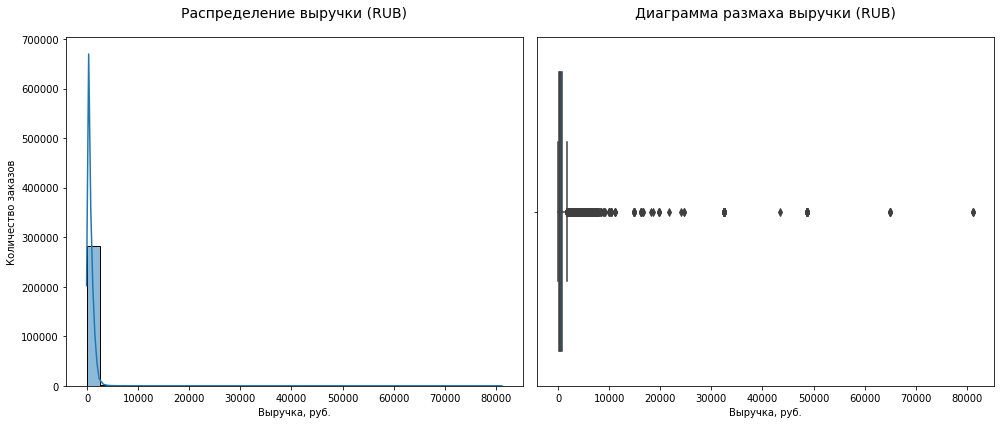

In [27]:
# Визуализируем распределение выручки от заказов.
# Гистограмма распределения данных:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_rub['revenue'], bins=30, kde=True)
plt.title('Распределение выручки (RUB)', pad=20, fontsize=14)
plt.xlabel('Выручка, руб.')
plt.ylabel('Количество заказов')

# "Ящик с усами":
plt.subplot(1, 2, 2)
sns.boxplot(x=df_rub['revenue'])
plt.title('Диаграмма размаха выручки (RUB)', pad=20, fontsize=14)
plt.xlabel('Выручка, руб.')
plt.tight_layout()
plt.show()

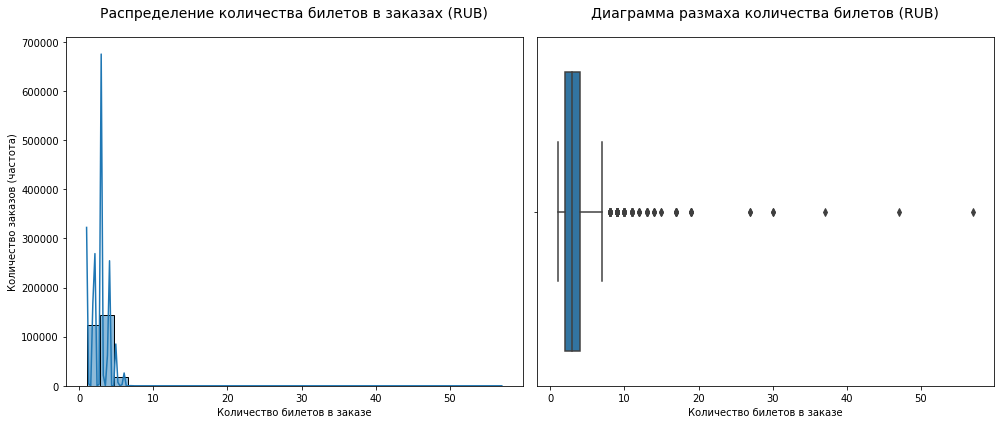

In [28]:
# Представим визуализацию распределения количества заказанных билетов.
# Гистограмма распределения данных:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_rub['tickets_count'], bins=30, kde=True)
plt.title('Распределение количества билетов в заказах (RUB)', pad=20, fontsize=14)
plt.xlabel('Количество билетов в заказе')
plt.ylabel('Количество заказов (частота)')

# "Ящик с усами":
plt.subplot(1, 2, 2)
sns.boxplot(x=df_rub['tickets_count'])
plt.title('Диаграмма размаха количества билетов (RUB)', pad=20, fontsize=14)
plt.xlabel('Количество билетов в заказе')
plt.tight_layout()
plt.show()


Фильтрация выбросов для RUB:
99-й процентиль: 2570.80
Удалено записей: 2800


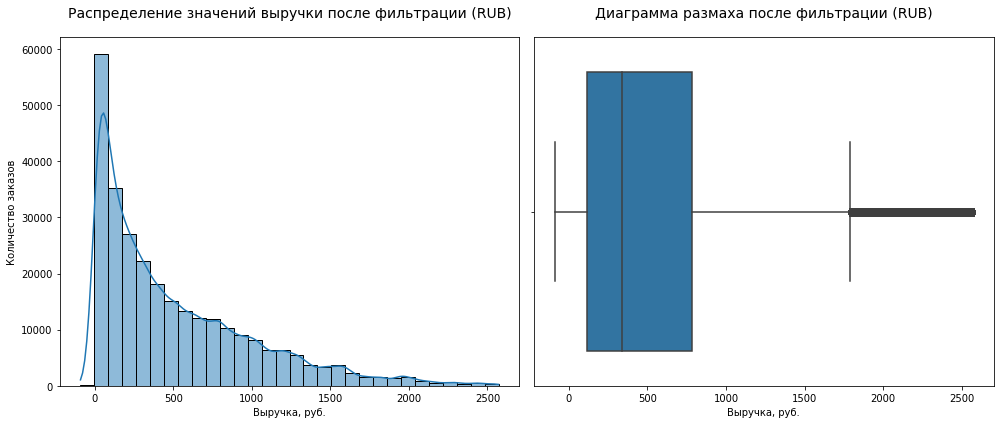

In [29]:
# Проведем фильтрацию выбросов по данным выручки по 99-му процентилю: 
threshold_rub = df_rub['revenue'].quantile(0.99)
df_rub_filtered = df_rub[df_rub['revenue'] <= threshold_rub]

print("\nФильтрация выбросов для RUB:")
print(f"99-й процентиль: {threshold_rub:.2f}")
print(f"Удалено записей: {len(df_rub) - len(df_rub_filtered)}")

# Визуализация после фильтрации
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_rub_filtered['revenue'], bins=30, kde=True)
plt.title('Распределение значений выручки после фильтрации (RUB)', pad=20, fontsize=14)
plt.xlabel('Выручка, руб.')
plt.ylabel('Количество заказов')


plt.subplot(1, 2, 2)
sns.boxplot(x=df_rub_filtered['revenue'])
plt.title('Диаграмма размаха после фильтрации (RUB)', pad=20, fontsize=14)
plt.xlabel('Выручка, руб.')
plt.tight_layout()
plt.show()

In [30]:
# Выведем основные показатели статистики после фильтрации для выручки (RUB):
print('Revenue:')
print(df_rub_filtered['revenue'].describe(percentiles=[0.25, 0.5, 0.99]))

Revenue:
count    282712.000000
mean        510.826965
std         500.935974
min         -90.760002
25%         112.129997
50%         340.669998
99%        2097.919922
max        2570.800049
Name: revenue, dtype: float64


**Анализ статистических показателей и распределения данных выручки и количества купленных билетов для тенге (KZT)**

In [31]:
# Выведем показатели описательной статистики:
print('\n[Анализ KZT] Описательная статистика:')
print('Revenue:')
print(df_kzt['revenue'].describe(percentiles=[0.25, 0.5, 0.99]))
print('\nTickets_count:')
print(df_kzt['tickets_count'].describe(percentiles=[0.25, 0.5, 0.99]))


[Анализ KZT] Описательная статистика:
Revenue:
count     5069.000000
mean      4995.207031
std       4916.752930
min          0.000000
25%        518.099976
50%       3698.830078
99%      17617.240234
max      26425.859375
Name: revenue, dtype: float64

Tickets_count:
count    5069.000000
mean        2.762872
std         1.115558
min         1.000000
25%         2.000000
50%         3.000000
99%         6.000000
max         6.000000
Name: tickets_count, dtype: float64


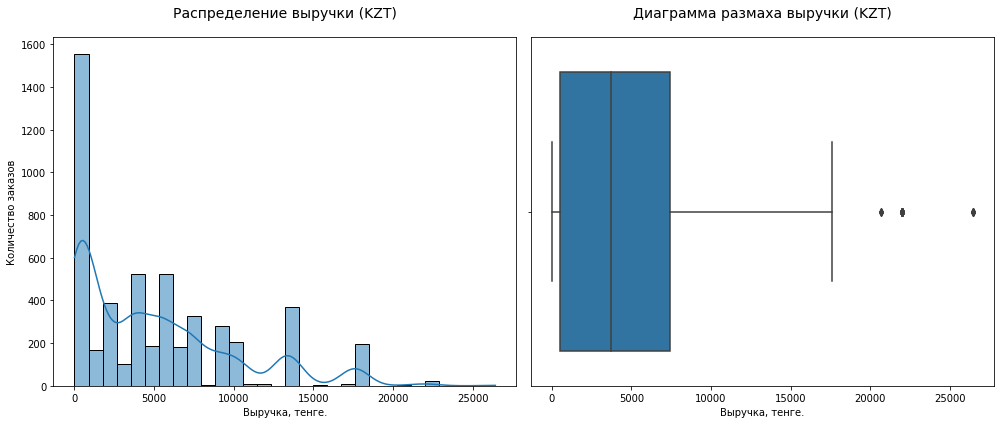

In [32]:
# Визуализируем распределение выручки от заказов.
# Гистограмма распределения данных:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_kzt['revenue'], bins=30, kde=True)
plt.title('Распределение выручки (KZT)', pad=20, fontsize=14)
plt.xlabel('Выручка, тенге.')
plt.ylabel('Количество заказов')

# "Ящик с усами":
plt.subplot(1, 2, 2)
sns.boxplot(x=df_kzt['revenue'])
plt.title('Диаграмма размаха выручки (KZT)', pad=20, fontsize=14)
plt.xlabel('Выручка, тенге.')
plt.tight_layout()
plt.show()

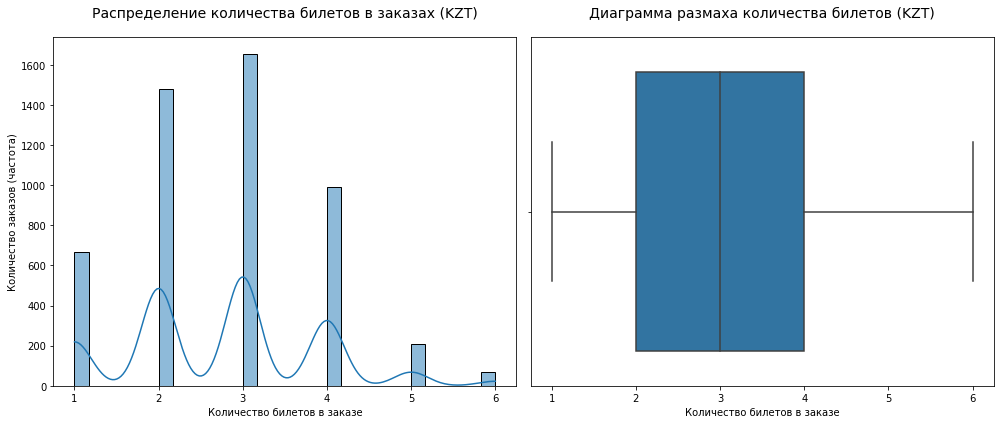

In [33]:
# Представим визуализацию распределения количества заказанных билетов.
# Гистограмма распределения данных:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_kzt['tickets_count'], bins=30, kde=True)
plt.title('Распределение количества билетов в заказах (KZT)', pad=20, fontsize=14)
plt.xlabel('Количество билетов в заказе')
plt.ylabel('Количество заказов (частота)')

# "Ящик с усами":
plt.subplot(1, 2, 2)
sns.boxplot(x=df_kzt['tickets_count'])
plt.title('Диаграмма размаха количества билетов (KZT)', pad=20, fontsize=14)
plt.xlabel('Количество билетов в заказе')
plt.tight_layout()
plt.show()


Фильтрация выбросов для KZT:
99-й процентиль: 17617.24
Удалено записей: 29


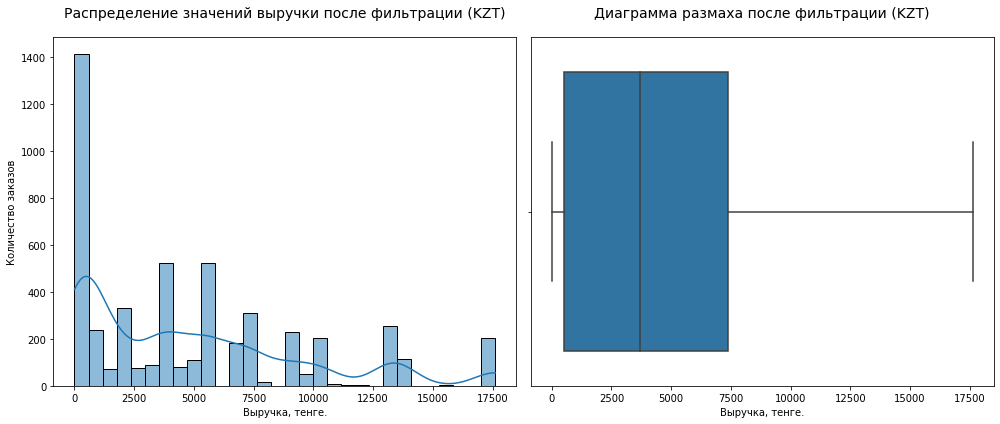

In [34]:
# Проведем фильтрацию выбросов по данным выручки по 99-му процентилю: 
threshold_kzt = df_kzt['revenue'].quantile(0.99)
df_kzt_filtered = df_kzt[df_kzt['revenue'] <= threshold_kzt]

print("\nФильтрация выбросов для KZT:")
print(f"99-й процентиль: {threshold_kzt:.2f}")
print(f"Удалено записей: {len(df_kzt) - len(df_kzt_filtered)}")

# Визуализация после фильтрации
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_kzt_filtered['revenue'], bins=30, kde=True)
plt.title('Распределение значений выручки после фильтрации (KZT)', pad=20, fontsize=14)
plt.xlabel('Выручка, тенге.')
plt.ylabel('Количество заказов')


plt.subplot(1, 2, 2)
sns.boxplot(x=df_kzt_filtered['revenue'])
plt.title('Диаграмма размаха после фильтрации (KZT)', pad=20, fontsize=14)
plt.xlabel('Выручка, тенге.')
plt.tight_layout()
plt.show()

In [35]:
# Выведем основные показатели статистики после фильтрации для выручки (KZT):
print('Revenue:')
print(df_kzt_filtered['revenue'].describe(percentiles=[0.25, 0.5, 0.99]))

Revenue:
count     5040.000000
mean      4893.668945
std       4742.680176
min          0.000000
25%        515.349983
50%       3698.830078
99%      17617.240234
max      17617.240234
Name: revenue, dtype: float64


Соберем отфильтрованные данные в единый датафрейм `filtr_df`.

In [36]:
# Используя функцию concat() объединим отфильтрованные данные:
filtr_df = pd.concat([df_rub_filtered, df_kzt_filtered])
print('\nИтоговый размер отфильтрованных данных:', filtr_df.shape)


Итоговый размер отфильтрованных данных: (287752, 32)


---

### Cделаем промежуточный вывод относительно проведенной предобработки данных:




**1.** Изначально провели объединение трех таблиц: `orders`, `events` и `tenge` в датафрейм `total_df`.

**2.** Выяснили, что пропуски в дадафрейме отсутствуют, кроме столбца `days_since_prev`, в котором пропуски оставлены без изменений.

**3.** Провели преобразование некоторых стобцов к соответствующим типам данных, а именно: 
- `days_since_prev` к целочисленному типу данных;
- `created_dt_msk`, `created_ts_msk` и `data` - к формату datetime64.

**4.** Оптимизировали размерность числовых столбцов.

**5.** Провели работу по выявлению явных и неявных дубликатов. Для этого нормализовали текстовые значения всех столбцов датафрейма и проанализировали их уникальные значения. В столбце `event_type_description` (описание мероприятий) некоторые значения привели к единому названию. В итоге, явные дубликаты во всем датафрейме не найдены, а дублирующие значения в связке столбцов `user_id`, `created_dt_msk`, `created_ts_msk`, `cinema_circuit`, `age_limit`, `currency_code`, `device_type_canonical`, `revenue`, `service_name`, `tickets_count`, `total`, `days_since_prev`, `event_id`, `venue_id`,`event_name` (бронирование билетов без учета идентификаторов заказа) обнаружены в количестве 58 и удалены.

**6.** По условиям задачи в датафрейме были добавлены дополнительные столбцы: `revenue_rub` - выручка с заказа в единой валюте (рубли), `one_ticket_revenue_rub` - выручка с продажи одного билета, `month` - месяц оформления заказа, `season` - информация о сезонности с категориями: "лето", "осень", "зима" и "весна".

**7.** Изучили распределение данных и наличие выбросов по выручке и количеству билетов в заказах в разрезе каждой валюты, а именно:
- вывели показатели описательной статистики;
- представили гистограмму распределения выручки в зависимости от числа заказов, а также диаграмму размаха, с помощью которой визуально определяются выбросы;
- рассчетным способом по 99-му процентилю выявили выбросы и удалили их;
- представили статистические показатели и визуализации выручки по отфильтрованным данным в рублях и тенге. Оба распределения правосторонние (с положительной ассиметрией).

**8.** Данные после фильтрации объединили в единый датафрейм `filtr_df`, содержащий 287752 строки и 32 столбца. 

---

## Исследовательский анализ данных

### Анализ распределения заказов по сегментам и их сезонные изменения

* **Проанализируем влияние сезонности на общее количество заказов с июня по октябрь 2024г. включительно.**

In [37]:
# Сгруппируем по месяцам и выведем количество заказов для каждого месяца:
monthly_orders = filtr_df.groupby('month')['order_id'].count()
print(monthly_orders)

month
6     34164
7     40407
8     44550
9     69352
10    99279
Name: order_id, dtype: int64


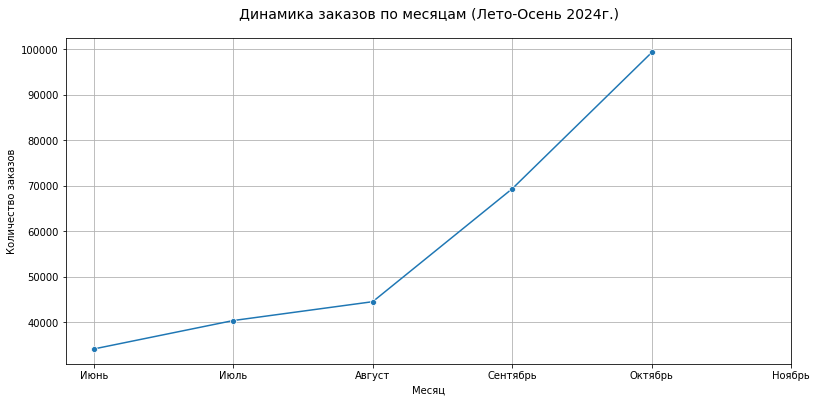

In [38]:
# Завизуализируем полученный результат:
plt.figure(figsize=(13, 6))

sns.lineplot(x=monthly_orders.index, y=monthly_orders.values, marker='o')
plt.title('Динамика заказов по месяцам (Лето-Осень 2024г.)', pad=20, fontsize=14)
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.xticks(range(6, 12), ['Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь'])
plt.grid(True)
plt.show()

*График действительно подтверждает резкое увеличение активности пользователей с наступлением осени. Количество заказов с начала сентября к концу октября увеличилось практически в два раза.*

* **Сравним летнее и осеннее распределение числа заказов в разрезе сигментов.** 

In [39]:
# Разделим данные по-сезонно: летние месяцы и осенние:
summer = filtr_df[filtr_df['month'].isin([6, 7, 8])]
autumn = filtr_df[filtr_df['month'].isin([9, 10])]

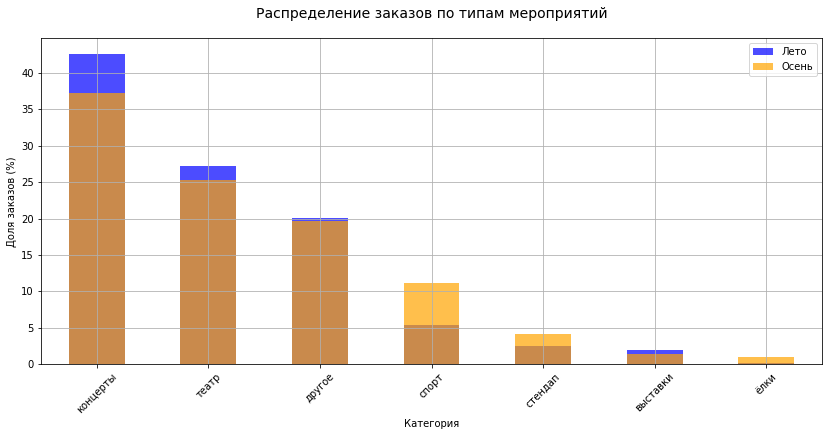

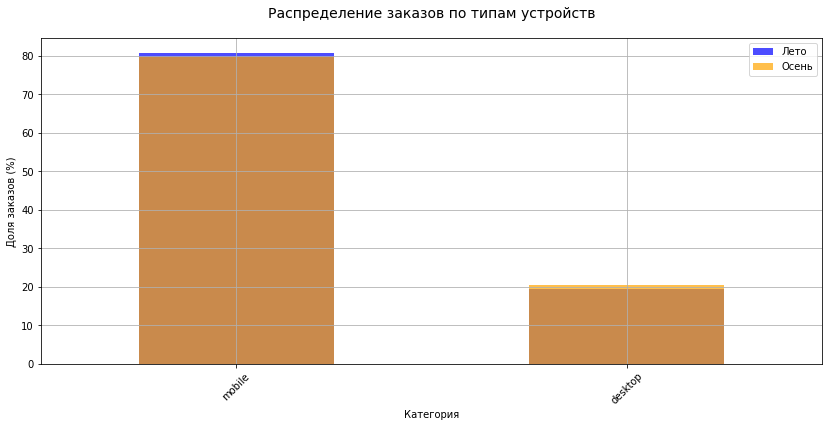

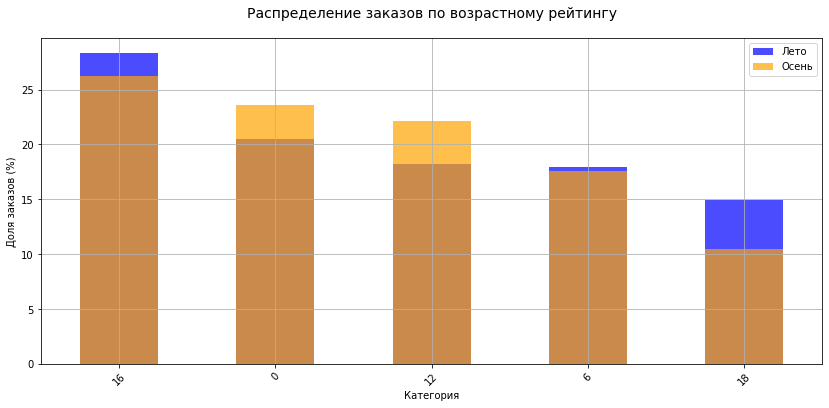

In [40]:
# Создадим функцию plot_seasonal_comparison, которая будет сравнивать доли заказов по категориям 
# (тип мероприятия, тип устройство и возрастной рейтинг) в зависимости от сезона:
def plot_seasonal_comparison(data_summer, data_autumn, column, title):
    summer_share = data_summer[column].value_counts(normalize=True) * 100
    autumn_share = data_autumn[column].value_counts(normalize=True) * 100
    
    # Добавим визуализацию результатов:
    plt.figure(figsize=(14, 6))
    summer_share.plot(kind='bar', color='blue', alpha=0.7, label='Лето')
    autumn_share.plot(kind='bar', color='orange', alpha=0.7, label='Осень')
    plt.title(f'Распределение заказов по {title}', pad=20, fontsize=14)
    plt.xlabel('Категория')
    plt.ylabel('Доля заказов (%)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

# Сравнение по типам мероприятий:
plot_seasonal_comparison(summer, autumn, 'event_type_main', 'типам мероприятий')

# Сравнение по устройствам:
plot_seasonal_comparison(summer, autumn, 'device_type_canonical', 'типам устройств')

# Сравнение по возрастному рейтингу:
plot_seasonal_comparison(summer, autumn, 'age_limit', 'возрастному рейтингу')

*По полученным визуальзациям видно, что пользовател сервиса Яндекс Афиша летом больше посещают концерты, театры, выставки и мероприятия категории "Другое" (незначительно), а осенью приобретают популярность спортивные мероприятия (популярность возрастает в два раза), стендапы и новогодние мероприятия. Также, зафиксируем, что летом пользователи предпочитают совершать заказы через мобильные устройства, а осенью - с помощью стационарных. В возрастной категории - летом наиболее популярны мероприятия с возрастными ограничениями особенно 18+, 16+ и 6+ (незначительно), а в осенний период - набирают популярность мероприятия с возрастным ограничением 12+ и О.*

* **Изучим изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью.**

In [41]:
# Добавим столбец с ценой билета в зависимости от сезона:
summer['ticket_price'] = summer['revenue'] / summer['tickets_count']
autumn['ticket_price'] = autumn['revenue'] / autumn['tickets_count']

# Группируем по типу мероприятия и считаем среднюю цену билета:
summer_avg = summer.groupby('event_type_main')['ticket_price'].mean()
autumn_avg = autumn.groupby('event_type_main')['ticket_price'].mean()

# Объединим результаты в один датафрейм:
price_comp = pd.DataFrame({
    'summer_price': summer_avg,
    'autumn_price': autumn_avg
})

# Рассчитаем абсолютное и относительное изменение:
price_comp['price_diff'] = price_comp['autumn_price'] - price_comp['summer_price']
price_comp['price_change_%'] = (price_comp['price_diff'] / price_comp['summer_price']) * 100

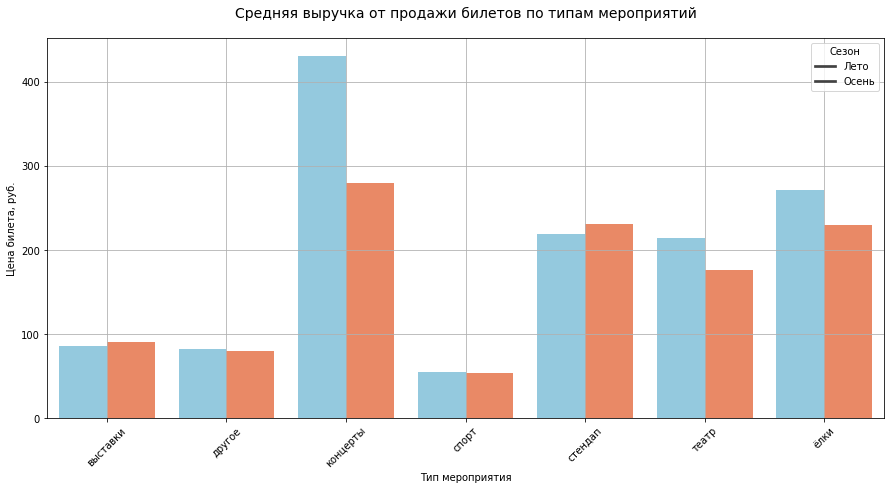

In [42]:
# Создадим визуализацию сравнения средней стоимости билета по мероприятиям летом и осенью:
price_comparison_melted = price_comp.reset_index().melt(
    id_vars='event_type_main',
    value_vars=['summer_price', 'autumn_price'],
    var_name='season',
    value_name='price'
)

plt.figure(figsize=(15, 7))
sns.barplot(x='event_type_main', 
            y='price', 
            hue='season',
            data=price_comparison_melted,
            palette={'summer_price': 'skyblue', 'autumn_price': 'coral'})

plt.title('Средняя выручка от продажи билетов по типам мероприятий', pad=20, fontsize=14)
plt.xlabel('Тип мероприятия')
plt.ylabel('Цена билета, руб.')
plt.legend(title='Сезон', labels=['Лето', 'Осень'])
plt.xticks(rotation=45)
plt.grid()
plt.show()

*Видно, что в летний период средняя выручка выше от продажи билетов на концерты, елки и в театры. А осенью значение средней выручки от продажи билетов на стендап и выставки незначительно превышает летние показатели. Средняя стоимость билетов на спортивные мероприятия и мероприятия категории "Другое" практически одинакова в летний и осенний периоды.*

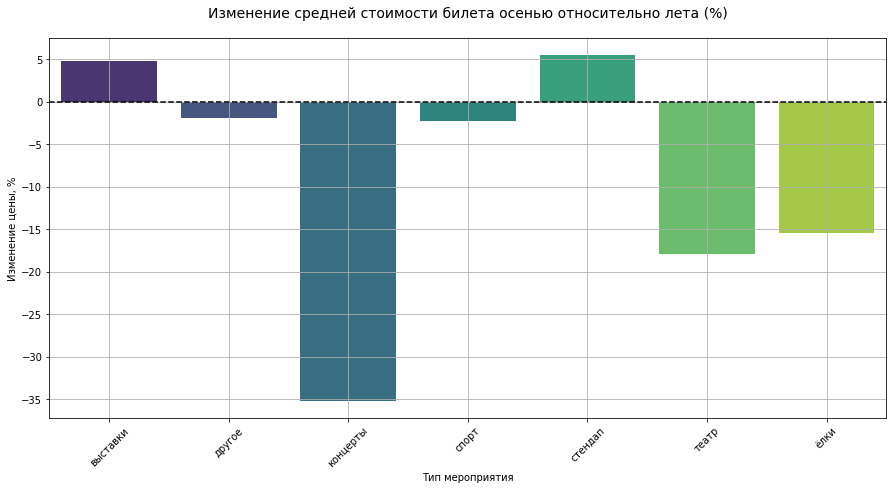

In [43]:
# Представим график изменения выручки осеннего периода по сравнению с летним:
plt.figure(figsize=(15, 7))
sns.barplot(x=price_comp.index, 
            y='price_change_%', 
            data=price_comp.reset_index(),
            palette='viridis')

plt.axhline(0, color='black', linestyle='--')
plt.title('Изменение средней стоимости билета осенью относительно лета (%)', pad=20, fontsize=14)
plt.xlabel('Тип мероприятия')
plt.ylabel('Изменение цены, %')
plt.xticks(rotation=45)
plt.grid()
plt.show()

*График отображает, что показатели стоимости выше ноля свидетельствуют о повышении цены билета на определенное мероприятие осенью по сравнению с летом. И, соответственно, значения ниже нулевой отметки говоят о снижении стоимости билета осенью. Значит, в осенний период цены на билеты увеличиваются, примерно, на 5% на посещение выставок и стендапов. А значительное снижение цен осенью наблюдается на билеты концертов (около 35%). Так же чуть более 15% цены осенью снижаются на театры и елки. Стоимости билетов на спортивные мероприятия и категории "Другое" практически постоянны (снижение цены осенью не более, чем на 3%).*

* **Подитожим:** *с наступлением осени активность пользователей сервиса Яндекс Афиша значительно повышается. Становятся очень популярными спортивные мероприятия, а также стендапы и мероприятия категории "Елки", хотя летом больше популярные концерты, театры и высавки. Стоимость билетов в осенний период по сравнению с летним на спортивные мероприятия и категории "Елки" незначительно падает (на 3% и 16% соответственно), а на стендапы  повышается, примерно на 5%. Существенное падение цен на билеты наблюдается в категоии "Концерты" - 35%. Летом  популярны мероприятия с возрастным ограничением 18+ и 16+, а в осенний период потенциальных покупателей больше интересуют мероприятия, рассчитанные зрителей: 12+ и без возрастного ограничения.*

### Изучение осенней активности пользователей

* **Проанализируем динамику изменений по дням для:**


* общего числа заказов;
* количества активных пользователей DAU;
* среднего числа заказов на одного пользователя;
* средней стоимости одного билета.

Выведем эти показатели в сводной таблице.

In [44]:
# Обратимся к ранеее созданной переменной autumn, 
# содержащей данные за два осенних месяца (сентябрь и октябрь 2024), и 
# создадим сводную таблицу:
daily_metrics = autumn.groupby('created_dt_msk').agg(
    total_orders=('order_id', 'count'), # Общее число заказов
    dau=('user_id', 'nunique'), # Уникальные пользователи (DAU)
    avg_ticket_price=('ticket_price', 'mean'), # Средняя стоимость билета
).reset_index()

# Добавим метрику "среднее число заказов на пользователя":
daily_metrics['orders_per_user'] = daily_metrics['total_orders'] / daily_metrics['dau']

display(daily_metrics)

,created_dt_msk,total_orders,dau,avg_ticket_price,orders_per_user
0,2024-09-01,1327,564,202.947678,2.352837
1,2024-09-02,1380,574,209.150574,2.404181
2,2024-09-03,5113,778,85.791336,6.571979
3,2024-09-04,1773,686,203.416611,2.584548
4,2024-09-05,1944,739,215.397751,2.630582
...,...,...,...,...,...
56,2024-10-27,2849,1034,188.802444,2.755319
57,2024-10-28,2838,985,172.596710,2.881218
58,2024-10-29,2836,998,180.071823,2.841683
59,2024-10-30,2927,1039,190.875580,2.817132


Визуализируем данные показатели по дням, используя линейный график.

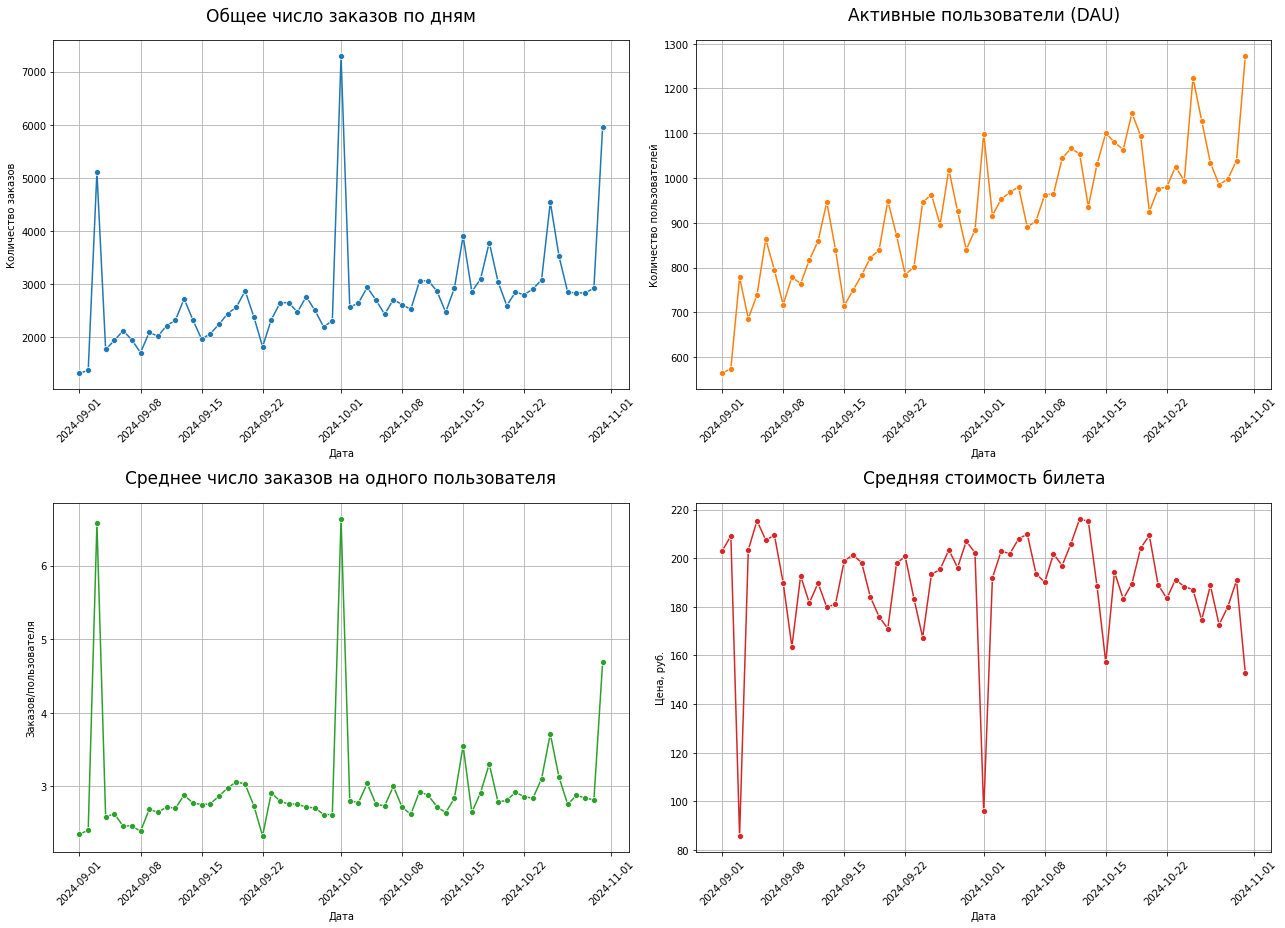

In [45]:
plt.figure(figsize=(18, 13))

# График 1: Общее число заказов
plt.subplot(2, 2, 1)
sns.lineplot(x='created_dt_msk', y='total_orders', data=daily_metrics, marker='o', color='#1f77b4')
plt.title('Общее число заказов по дням', pad=20, fontsize=17)
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45)
plt.grid()

# График 2: DAU (уникальные пользователи)
plt.subplot(2, 2, 2)
sns.lineplot(x='created_dt_msk', y='dau', data=daily_metrics, marker='o', color='#ff7f0e')
plt.title('Активные пользователи (DAU)', pad=20, fontsize=17)
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)
plt.grid()

# График 3: Заказов на пользователя
plt.subplot(2, 2, 3)
sns.lineplot(x='created_dt_msk', y='orders_per_user', data=daily_metrics, marker='o', color='#2ca02c')
plt.title('Среднее число заказов на одного пользователя', pad=20, fontsize=17)
plt.xlabel('Дата')
plt.ylabel('Заказов/пользователя')
plt.xticks(rotation=45)
plt.grid()

# График 4: Средняя стоимость билета
plt.subplot(2, 2, 4)
sns.lineplot(x='created_dt_msk', y='avg_ticket_price', data=daily_metrics, marker='o', color='#d62728')
plt.title('Средняя стоимость билета', pad=20, fontsize=17)
plt.xlabel('Дата')
plt.ylabel('Цена, руб.')
plt.xticks(rotation=45)
plt.grid()

plt.tight_layout()
plt.show()

*На графиках хорошо прослеживается взаимосвязь всех четырех показателей. Во-первых, наблюдается стабильный рост числа активных пользователей в осенний период, который прямо пропорционален увеличению общего числа заказов. Чем выше активность пользователей, тем больше число заказов и, следовательно, выше среднее количество заказов на одного пользователя. И это непосредственно связанно со средней стоимостью билета - на графиках отлично отображена дневная динамика зависимости средней стоимости билета с активностью поьзователей и, соответственно, с числом заказов.*

* ***Изучим недельную цикличность. Выделим день недели и сравним пользовательскую активность в будни и выходные.***

In [46]:
# Добавим в таблицу daily_metrics столбец с днем недели и типом дня (будни/выходные):
daily_metrics['day_of_week'] = pd.to_datetime(daily_metrics['created_dt_msk']).dt.day_name()
daily_metrics['is_weekend'] = daily_metrics['day_of_week'].isin(['Saturday', 'Sunday'])

# Сравним средние значения показателей активности пользователей для будней и выходных:
weekday_stats = daily_metrics.groupby('is_weekend').agg({
    'total_orders': 'mean',
    'dau': 'mean',
    'orders_per_user': 'mean',
    'avg_ticket_price': 'mean'
}).rename(index={False: 'Будни', True: 'Выходные'})

print(weekday_stats)

            total_orders         dau  orders_per_user  avg_ticket_price
is_weekend                                                             
Будни        2906.772727  937.409091         3.065792        184.850784
Выходные     2396.058824  887.823529         2.675162        200.579407


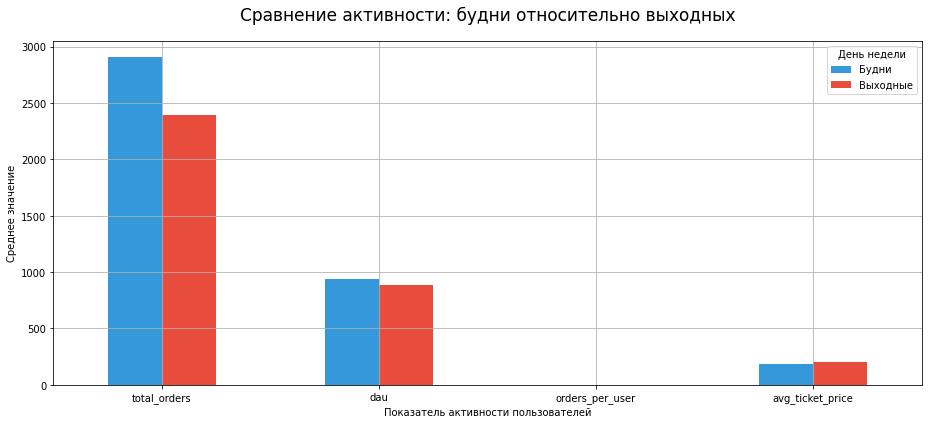

In [47]:
# Зададим параметры диаграммы:
fig, ax = plt.subplots(figsize=(13, 6))

# Построим график:
weekday_stats.T.plot(kind='bar', color=['#3498db', '#e74c3c'], ax=ax)

# Настройки графика
ax.set_title('Сравнение активности: будни относительно выходных', pad=20, fontsize=17)
ax.set_ylabel('Среднее значение')
ax.set_xlabel('Показатель активности пользователей')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title='День недели')
plt.grid()

plt.tight_layout()
plt.show()

*По рассчетным данным и полученной визуализации видно, что в будни активность пользователей (по общему числу заказов, количеству уникальных пользователей и числу заказов на одного пользователя) выше. А средняя стоимость билета в выходные дни незначительно выше, чем в будни, и это объяснимо.*

* **Подитожим:** *График активности пользователей в осенний период имеет восходящий тренд, а, следовательно, и увеличение общего числа заказов и среднее количество заказов на одного пользователя, что непосредственно связанно со средней стоимостью билета - чем ниже цена, тем больше заказов. Отметим, что в первые числа каждого осеннего месяца наблюдается резкое падение цен, что на графиках с заказами отражается как резкий рост. Возможно, это связанно с проведением каких-либо акций или мероприятий со специальными скидками на цены. Анализ показателей активности в недельной цикличности фиксирует, что в будни активность пользователей выше, а средняя цена билета, незначительно, но ниже, что вполне понятно.*

### Исследование зависимости популярности событий от регионов и партнеров 

* **Для каждого региона посчитаем уникальное количество мероприятий и общее число заказов и определим, в каких регионах предлагается наибольшее разнообразие мероприятий.**

In [48]:
# Проведем группировку количества мероприятий и заказов по регионам:
region_stats = filtr_df.groupby('region_name').agg(
    unique_events=('event_id', 'nunique'), # Уникальные мероприятия
    total_orders=('order_id', 'count') # Общее число заказов
).sort_values('unique_events', ascending=False)

# Посчитаем относительные значения:
region_stats['events_share'] = round((region_stats['unique_events'] / region_stats['unique_events'].sum()) * 100, 2)
region_stats['orders_share'] = round((region_stats['total_orders'] / region_stats['total_orders'].sum()) * 100, 2)

# Сохраним ТОП-7 регионов в отдельную переменную top7_regions и выведем их на экран:
top7_regions = region_stats.head(7)
display(top7_regions)

,unique_events,total_orders,events_share,orders_share
region_name,,,,
каменевский регион,5935,89665,26.54,31.16
североярская область,3800,43739,17.00,15.20
широковская область,1232,16169,5.51,5.62
светополянский округ,1075,7502,4.81,2.61
речиновская область,702,6267,3.14,2.18
травяная область,683,5036,3.05,1.75
горицветская область,551,5153,2.46,1.79


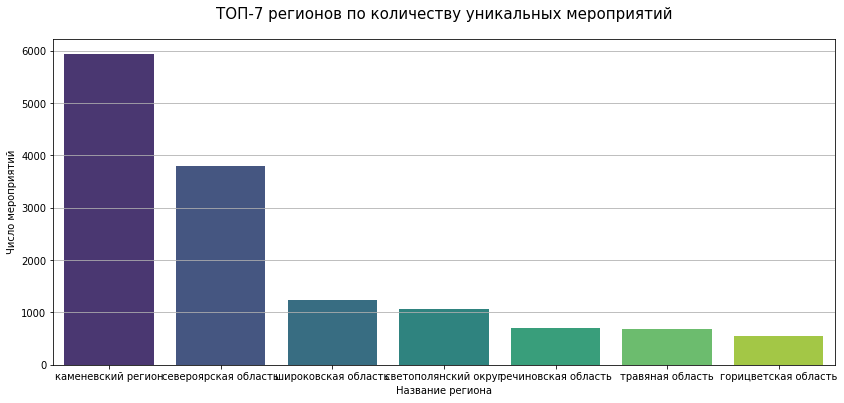

In [49]:
# Создадим график распределения самых популярных регионов по количеству уникальных мероприятий:
plt.figure(figsize=(14, 6))
sns.barplot(x=top7_regions.index, y='unique_events', data=top7_regions, palette='viridis')
plt.title('ТОП-7 регионов по количеству уникальных мероприятий', pad=20, fontsize=15)
plt.xlabel('Название региона')
plt.ylabel('Число мероприятий')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

*Видно, что по количеству мероприятий явные лидирующие позиции занимают два региона: Каменевский регион - 5935 уникальных событий за летне-осенний период и Североярская область - 3800. Значит, эти регионы приносят львинную долю выручки от продажи всех билетов.*

* **Перейдем к анализу партнеров и определим ключевых партнеров по объему продаж и количеству мероприятий.**

In [50]:
# Сгруппируем агрегированные данные по билетным операторам (партнерам):
partner_stats = filtr_df.groupby('service_name').agg(
    total_revenue=('revenue', 'sum'), # Общая выручка
    unique_events=('event_id', 'nunique'), # Уникальные мероприятия 
    total_orders=('order_id', 'count') # Общее число заказов
).sort_values('total_revenue', ascending=False)

# Добавим долю выручки:
partner_stats['revenue_share'] = round((partner_stats['total_revenue'] / 
                                        partner_stats['total_revenue'].sum()) * 100, 2)
# Сохраним ТОП-7 партнеров в отдельную переменную top7_partner и выведем их на экран:
top7_partner = partner_stats.head(7)
display(top7_partner)


,total_revenue,unique_events,total_orders,revenue_share
service_name,,,,
мой билет,39390728.0,1300,34440,23.299999
билеты без проблем,26495642.0,4247,62858,15.670000
облачко,18588614.0,2335,26402,10.990000
лови билет!,16675475.0,4867,40802,9.860000
весь в билетах,16533231.0,855,16425,9.780000
билеты в руки,13194330.0,3530,40281,7.800000
край билетов,6405689.0,252,6109,3.790000


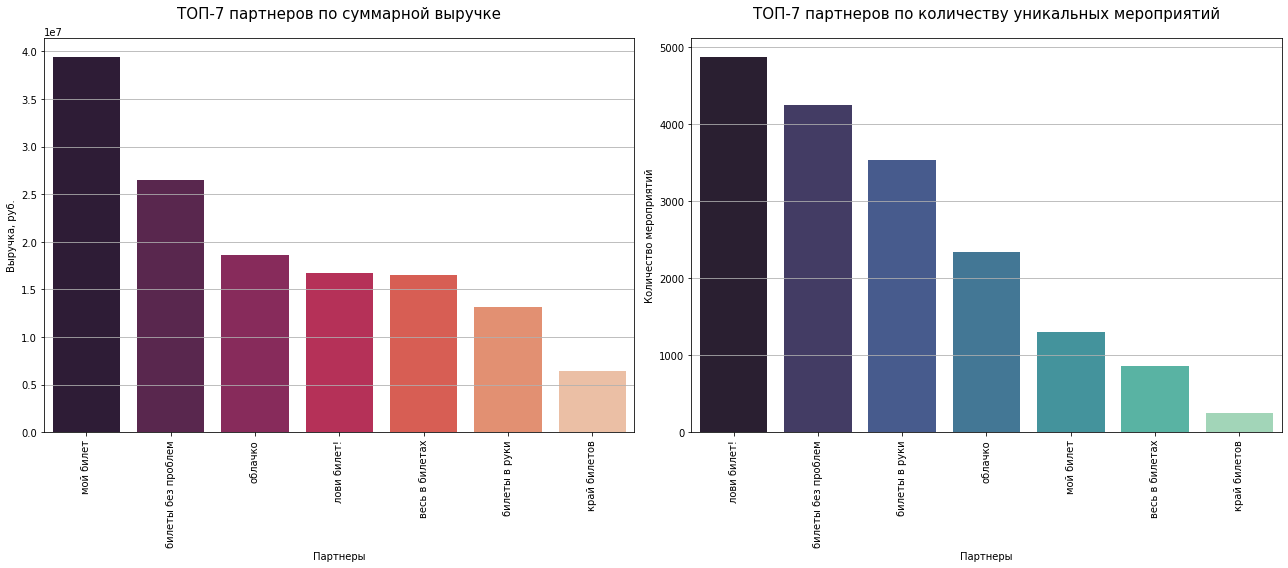

In [51]:
# Зададим параметры визуализации:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# График 1: Партнеры с максимальной выручкой:
sns.barplot(x=top7_partner.index, y='total_revenue', data=top7_partner, ax=axes[0], palette='rocket')
axes[0].set_title('ТОП-7 партнеров по суммарной выручке', pad=20, fontsize=15)
axes[0].set_xlabel('Партнеры')
axes[0].set_ylabel('Выручка, руб.')
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid(axis='y')

# График 2: По максимальному количеству мероприятий:
sns.barplot(x=top7_partner.sort_values('unique_events', ascending=False).index, y='unique_events', 
            data=top7_partner.sort_values('unique_events', ascending=False), ax=axes[1], palette='mako')
axes[1].set_title('ТОП-7 партнеров по количеству уникальных мероприятий', pad=20, fontsize=15)
axes[1].set_xlabel('Партнеры')
axes[1].set_ylabel('Количество мероприятий')
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

*По полученным результатам видно, что максимальные суммы выручки за исследуемый период принесли следующие билетные опреаторы: "мой билет" - 39,4 млн.руб. и "билеты без проблем" - 26,5 млн.руб.. А по наибольшему числу уникальных событий лидируют: "лови билет!" - 4867 заказов и "билеты без проблем" - 4247. Билетный партнер "билеты без проблем" уверенно лидирует на втором месте по двум позициям!*

* **Подитожим:** *Cудя по расчетным и графическим распределениям данных за летне-осенний период 2024, выделили ТОП-7 регионов (по числу уникальных мероприятий) и ТОП-7 билетных партнеров (по суммарной выручке). Лидерами среди регионов в данных позициях стали: Каменевский регион - 5935 уникальных событий и Североярская область - 3800. А среди билетных опреаторов можно выделить следующих (по выручке): "мой билет" - 39,4 млн.руб. и "билеты без проблем" - 26,5 млн.руб.; по наибольшему числу уникальных событий: "лови билет!" - 4867 заказов и "билеты без проблем" - 4247. Отметим, что билетный партнер "билеты без проблем" уверенно занимает второе месте по двум позициям! Можно предположить, что лидирующие билетные операторы расположены в регионах, входящих в ТОП-7.*

##  Статистический анализ данных

* **В данном разделе проведем отдельную проверку двух гипотез, которые предполагают большую активность пользователей мобильных устройств. В работе будем использовать датафрейм `autumn`, содержащий данные за осенний период.**

### Гипотеза 1: Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.

Попробуем статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- **Нулевая гипотеза H₀:** Среднее количество заказов на пользователя для мобильных устройств не выше, чем для стационарных.

- **Альтернативная гипотеза H₁:** Среднее количество заказов на пользователя выше для мобильных устройств и это различие статистически значимо.

In [52]:
# Разделим "осенних" пользователей c заказами по типам устройств:
mobile_orders = autumn[autumn['device_type_canonical'] == 'mobile'].groupby('user_id')['order_id'].count()
desktop_orders = autumn[autumn['device_type_canonical'] == 'desktop'].groupby('user_id')['order_id'].count()

# Выведем результат сравнения групп (размер выборок и среднее количесвто заказов на пользователя):
print(f'Мобильные устройства: n={len(mobile_orders)}, mean={mobile_orders.mean():.2f}')
print(f'Стационарные устройства: n={len(desktop_orders)}, mean={desktop_orders.mean():.2f}')

Мобильные устройства: n=14192, mean=9.47
Стационарные устройства: n=4868, mean=7.05


*В данном случае, вероятней всего, будем применять t-тест Уэлча, т.к. в нашем случае проводится анализ средник пользовательских метрик, и размеры выборок существенно отличаются друг от друга - группа 'mobile_orders' в три раза больше 'desktop_orders'. Проверим условия для выполнения выбранного теста:*

- *выборки должны быть независимы;*
- *независимость от равенства выборочных дисперсий.*

**Проверка независимости значений в выборках (отсутствие пересечений).**

In [53]:
# Проверка на пересечение поьзователей: 
common_users = set(mobile_orders.index) & set(desktop_orders.index)
print(f'Общих пользователей: {len(common_users)}')

Общих пользователей: 3249


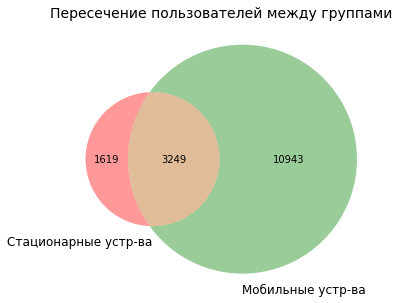

In [54]:
# Подтвердим пересечение визуально с помощью диаграммы Венна:
plt.figure(figsize=(12, 5))
venn2([set(desktop_orders.index), set(mobile_orders.index)], ('Стационарные устр-ва', 'Мобильные устр-ва'))
plt.title('Пересечение пользователей между группами', fontsize=14)
plt.show()

*По полученным результатам видно, что есть 3429 пользователей, которые попали в обе выборки. Естественно, это нарушение проведения независимости тестов, результаты которых будут статистически некорректными. Удаленим таких пользователей из группы 'mobile_orders', оставив в группе 'desktop_orders', где количество наблюдений меньше.*

In [55]:
# Очистим группу пользователей с мобильными устройствами от пересечений:
clean_mobile = autumn[(autumn['device_type_canonical'] == 'mobile') & (~autumn['user_id'].isin(common_users))]

# Проведем агрегацию и выведем размер очищенной выборки и среднее выборочное:
clean_mobile_orders = clean_mobile.groupby('user_id')['order_id'].count()
print(f'Мобильные устройства (очищенные данные): n={len(clean_mobile_orders)}, mean={clean_mobile_orders.mean():.2f}')
print(f'Стационарные устройства: n={len(desktop_orders)}, mean={desktop_orders.mean():.2f}')

Мобильные устройства (очищенные данные): n=10943, mean=2.86
Стационарные устройства: n=4868, mean=7.05


**Проверка равенства дисперсий.**

In [56]:
# Проверим равенство выборочных дисперсий перед проведением t-теста с помощью теста Леване.
# Сформулируем гипотезы:
# - Н0: Дисперсии сравниваемых групп равны;
# - Н1: Дисперсии сравниваемых групп не равны.

alpha = 0.05

levene_test = stats.levene(clean_mobile_orders, desktop_orders)
print(f'Тест Леване: p-value = {levene_test.pvalue:.4f}', 
      'Нельзя отвергнуть Н0 (дисперсии равны)' if levene_test.pvalue > alpha else 'Отвергаем Н0 (дисперсии разные)')

Тест Леване: p-value = 0.0000 Отвергаем Н0 (дисперсии разные)


**Условия проверены - применяем односторонний t-тест Уэлча.**

In [57]:
# Односторонний тест (alternative='greater'):
welch_result = stats.ttest_ind(clean_mobile_orders, desktop_orders, 
                              equal_var=False,  # Используем тест Уэлча
                              alternative='greater')

print(f"\nРезультат t-теста Уэлча:")
print(f"t-статистика = {welch_result.statistic:.3f}")
print(f"p-value = {welch_result.pvalue:.3f}")


Результат t-теста Уэлча:
t-статистика = -8.097
p-value = 1.000


In [58]:
# Интерпретируем результаты:
alpha = 0.05

if welch_result.pvalue < alpha:
    print(f"\nПри p={welch_result.pvalue:.3f} отвергаем H₀. Мобильные пользователи совершают достоверно больше заказов.")
else:
    print(f"\nПри p={welch_result.pvalue:.3f} недостаточно оснований отвергнуть H₀.")


При p=1.000 недостаточно оснований отвергнуть H₀.


### Гипотеза 2: Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.


Так же проведем одностороннюю проверку гипотезы:

- **Нулевая гипотеза H₀:** Среднее время между заказами у "мобильных" пользователей не больше, чем у "стационарных".

- **Альтернативная гипотеза H₁:** Среднее время между заказами у "мобильных" пользователей значимо больше.

In [59]:
# Создадим функцию, которая рассчитает время между заказами для каждого пользователя (в днях):
def calc_time_diff(autumn):
    return (
        autumn.sort_values('created_dt_msk')
        .groupby('user_id')['created_dt_msk']
        .diff()  # Разница между заказами
        .dt.days  # Преобразуем в дни
        .dropna()  # Удаляем NaN (первые заказы)
    )

# Фильтруем данные по устройствам:
mobile_time_diff = calc_time_diff(autumn[autumn['device_type_canonical'] == 'mobile'])
desktop_time_diff = calc_time_diff(autumn[autumn['device_type_canonical'] == 'desktop'])

print(f"Мобильные: n={len(mobile_time_diff)}, mean={mobile_time_diff.mean():.1f} дней")
print(f"Десктоп: n={len(desktop_time_diff)}, mean={desktop_time_diff.mean():.1f} дней")

Мобильные: n=120136, mean=1.6 дней
Десктоп: n=29435, mean=1.8 дней


Перед выбором статистического теста необходимо проверить следующие условия:

- убедиться в независимости выборок (проведено ранее);
- проверить нормальность распределения (параметрический или непараметрический тест);
- оценить размер выборок и дисперсию.

**Проверим нормальность распределения данных.**

In [60]:
# Проверим, соответствуют ли выборки нормальному распределению. Для этого выполним тест Шапиро-Уилка. 
# Cформулируем гипотезы:
# - Н0: данные подчиняются нормальному распределению;
# - Н1: данные не подчиняются нормальному рапределению.

shapiro_mobile = stats.shapiro(mobile_time_diff)
shapiro_desktop = stats.shapiro(desktop_time_diff)

print(f"Нормальность мобильных данных: p-value = {shapiro_mobile.pvalue:.5f}")
print(f"Нормальность десктопных данных: p-value = {shapiro_desktop.pvalue:.5f}")

alpha = 0.05
if shapiro_mobile.pvalue > alpha and shapiro_desktop.pvalue > alpha:
    print("Данные нормальны → t-тест. Н0 подтверждается.")
else:
    print("Данные не нормальны → U-тест Манна-Уитни. Оснований для подтверждения Н0 нет.")

Нормальность мобильных данных: p-value = 0.00000
Нормальность десктопных данных: p-value = 0.00000
Данные не нормальны → U-тест Манна-Уитни. Оснований для подтверждения Н0 нет.


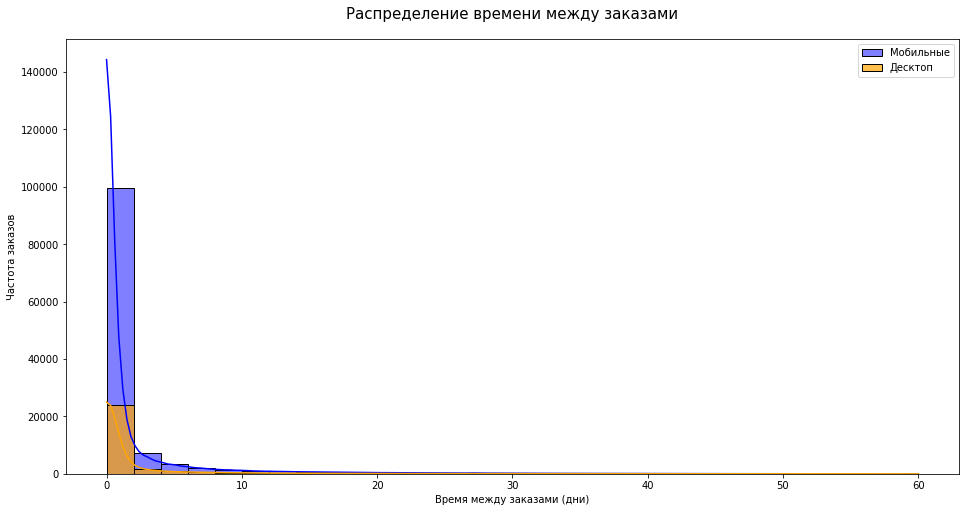

In [61]:
# Визуализируем распределение временного интервала между заказами по устройствам:
plt.figure(figsize=(16, 8))
sns.histplot(mobile_time_diff, bins=30, kde=True, color='blue', label='Мобильные')
sns.histplot(desktop_time_diff, bins=30, kde=True, color='orange', label='Десктоп', alpha=0.7)
plt.title('Распределение времени между заказами', pad=20, fontsize=15)
plt.xlabel('Время между заказами (дни)')
plt.ylabel('Частота заказов')
plt.legend()
plt.show()


*Исходя из проверки условий приминения статистического теста, для проверки гипотезы подойдет тест Манна-Уитни, т.к. он не зависит от нормальности данных и устойчив к выбросам, которые наблюдаются в количестве дней на гистограмме.*

In [62]:
# Проведем двухвыборочный t-тест Манна-Уитни (односторонний: Mobile > Desktop):
stat, p_value = stats.mannwhitneyu(
    mobile_time_diff, 
    desktop_time_diff, 
    alternative='greater'  
)
print('\nРезультат U-теста Манна-Уитни:')
print(f'U-статистика = {stat:.0f} - различия между значениями в группах несущественны, p-value = {p_value:.3f}')

# Выведем результат:
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: пользователи Санкт-Петербурга значимо больше времени проводят в приложении.')
else:
    print('Нет оснований отвергнуть нулевую гипотезу: различий нет или они не значимы.')


Результат U-теста Манна-Уитни:
U-статистика = 1756854651 - различия между значениями в группах несущественны, p-value = 0.983
Нет оснований отвергнуть нулевую гипотезу: различий нет или они не значимы.


* **Подитожим:** *Результаты проведенных статистических тестов для проверки предложенных гипотез подтверждают, что нет значимых оснований отвергать нулевые гипотезы о том, что среднее количество заказов и среднее время между ними пользователей мобильных устройств не превышают показатели для пользователей  стационарных устройств. Альтернативные гипотезы не подтвердились.*    

##  Общий вывод и рекомендации

* **Изложим информацию о данных, которые были использованы в проекте:**


Для проведения исследовательского анализа были предоставлены следующие файлы: `final_tickets_orders_df.csv`,
`final_tickets_events_df.csv` и `final_tickets_tenge_df.csv`, которые и были задействованы в работе. С данными этих датасетов был проведен большой объем работы относительно предварительной предобработки данных, а именно:


* объединение всех датасетов в единный датафрейм `total_df`;
* процесс оптимизации размерности данных и их преобразование;
* выявление и дальнейшая работа с явными и неявными дубликатами и пропусками;
* добавление в датафрейм дополнительных столбцов, необходимых по условию задачи: `revenue_rub`, `one_ticket_revenue_rub`, `month` и `season`;
* изучение распределения данных и наличия выбросов по выручке и количеству билетов в заказах в разрезе каждой валюты;
* объединение отфильтрованных данных в единый датафрейм `filtr_df`, содержащий 287752 строки и 32 столбца.


* **Рассмотрим основные результаты исследовательского анализа данных:**


1. С наступлением осени активность пользователей явно повышается. Резко возрастает популярность на спортивные мероприятия и стендапы (практчески в два раз!), а также мероприятия категории "Елки", хотя летом больше популярны концерты, театры и выставки (незначительно). В возрастной категории - летом наиболее популярны мероприятия с возрастными ограничениями особенно 18+, 16+ и 6+ (незначительно), а в осенний период - набирают популярность мероприятия с возрастным ограничением 12+ и О. Хотя значение средней выручки от продажи билетов в летне-осенний период на спортивные мероприятия практически неизменно. Осенью средний чек выше от продажи билетов на стендапы и выставки, а летом - от продажи билетов на концерты, мероприятия категории "Елки" и в театры. Что кассается изменения стоимости билета в осенний период по сравнению с летним, то цены на билеты увеличиваются, примерно, на 5% на посещение выставок и стендапов, значительное снижение цен осенью наблюдается на билеты концертов (около 35%). Так же чуть более 15% цены осенью снижаются на театры и елки. Стоимости билетов на спортивные мероприятия и категории "Другое" практически постоянны (снижение цены осенью не более, чем на 3%). Кроме того, стоит отметить, что летом пользователи предпочитают совершать заказы через мобильные устройства, а осенью - с помощью стационарных. Значит, летом они больше предпочитают находится на улице. 


2. Анализ осенней активности пользователей показывает, что с ростом числа активных пользователей  увеличивается и  общее число заказов и среднее количество заказов на одного пользователя, что непосредственно связанно со средней стоимостью билета - чем ниже цена, тем больше заказов. Также обратим внимание, что в первые числа каждого осеннего месяца наблюдается резкое падение цен, что на графиках с заказами отражается как резкий рост. Возможно, это связанно с проведением каких-либо акций или мероприятий со специальными скидками на цены. Анализ показателей активности в недельной цикличности фиксирует, что в будни активность пользователей выше, так как средняя цена билета, незначительно, но ниже.


3. Был определен список ТОП-7 регионов (по числу заказов) и партнеров (по выручке). За летне-осенний период 2024 по числу заказов самымми значимыми регионами стали: Каменевский регион - 5935 уникальных событий и Североярская область - 3800. Среди билетных операторов по суммарной выручке лидируют такие, как "мой билет" - 39,4 млн.руб. и "билеты без проблем" - 26,5 млн.руб., а по наибольшему числу уникальных событий: "лови билет!" - 4867 заказов и "билеты без проблем" - 4247. Отметим, что билетный партнер "билеты без проблем" уверенно занимает второе месте по двум позициям! Можно предположить, что лидирующие билетные операторы (ТОП-7) расположены в регионах, входящих в список ТОП-7.


* **Прокомментируем результаты проверки гипотез:**

Важным моментом в ходе выполнения данного проекта стало проведение статистического анализа данных, а именно: проверка двух отдельных гипотез: 

- среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств;
- среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Проверка первой гипотезы о среднем количестве заказов с помощью t-теста Уэлча не подтвердила альтернативную гипотезу, что на одного пользователя мобильного приложения приходится больше заказов по сравнению с пользователями стационарных устройств.

Используя статистический тест Манна-Уитни, проверка второй гипотезы о среднем времени между заказами также не нашла подтверждения альтернативной гипотезы, что для пользователей мобильных приложений среднее время между заказами выше по сравнению с пользователями стационарных устройств.

Значит тип устройства, которым пользуются потенциальные покупатели, не влияет ни на количество заказов, ни на интервал времени между ними.

* **В качестве рекомендаций:** 

На основании вышеизложенного можно предположить, что основное внимание нужно обратить на взаимосвязь между регионами из ТОП-7, типами мероприятий и выручкой, а также уникальным количеством пользователей, стоимостью билетов, преобладающей возрастной категорией и сезонностью проводимых мероприятий. Также стоит проанализировать действия билетных партнеров ТОП-7 и, возможно, выявить какие-то особенные факты в работе этих операторов, влияющие на высокие показатели количества заказов и выручки от проданных билетов. То есть, на начальном этапе важен анализ событий - концерты (особенно!) и театры в летний период, стендапы и спортивные мероприятия, хотя они не приносят много выручки, осенью (их количество, стоимость билетов, проводимые акции, возрастные ограничения), проводимых в Каменевском регионе и Североярской области, с учетом продажи билетов через партнеров "мой билет" и "билеты без проблем".